# Implementación DenseNet

In [1]:
!pip install umap-learn
import os
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
from sklearn.manifold import TSNE
from torch import Tensor
from typing import Type
import torch.nn.init as init
from google.colab import drive
drive.mount('/content/drive')

# Transformaciones para entrenamiento y validación
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),  # Recorte aleatorio después del padding
    torchvision.transforms.RandomHorizontalFlip(),      # Volteo horizontal aleatorio
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

val_test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Cargar datasets CIFAR-10 con transformaciones
train_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=True,
    download=True,
    transform=train_transform  # Se aplica data augmentation aquí
)

test_cifar10 = torchvision.datasets.CIFAR10(
    root="./cifar10",
    train=False,
    download=True,
    transform=val_test_transform  # Solo normalización para testing
)

# Dividir dataset de entrenamiento y validación
train_cifar10, _ = torch.utils.data.random_split(train_cifar10, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_cifar10 = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="./cifar10", train=True, transform=val_test_transform),
    [45000, 5000], generator=torch.Generator().manual_seed(42)
)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00
Mounted at /content/drive


100%|██████████| 170M/170M [00:08<00:00, 21.2MB/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


# Entrenamiento

In [2]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    # Asegúrate de que los datos estén en la CPU antes de convertirlos a NumPy
    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, np.array(curves['val_loss']), label='validation')
    ax[0].plot(epochs, np.array(curves['train_loss']), label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, np.array(curves['val_acc']), label='validation')
    ax[1].plot(epochs, np.array(curves['train_acc']), label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

# Visualize feature maps
def show_feature_maps(feature_maps):
    for layer_name, feature_map in feature_maps.items():
        fmap = feature_map[0].cpu().numpy()  # Convert to CPU and NumPy for visualization
        num_feature_maps = fmap.shape[0]

        # Plot a grid of feature maps (first 8 feature maps)
        fig, axes = plt.subplots(1, min(8, num_feature_maps), figsize=(20, 5))
        fig.suptitle(f"Feature Maps from Layer {layer_name}", fontsize=16)

        for i in range(min(8, num_feature_maps)):
            axes[i].imshow(fmap[i], cmap='viridis')
            axes[i].axis('off')

        plt.show()

def checkpoint_save(model, optimizer, epoch, filename):
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint_data, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint guardado en {os.path.join(checkpoint_dir, filename)}")

def checkpoint_resume(model, optimizer, filename):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.isfile(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        epoch = checkpoint_data['epoch']
        print(f"Checkpoint cargado desde '{checkpoint_path}' (época {epoch})")
        return epoch
    else:
        print(f"No se encontró ningún checkpoint en '{checkpoint_path}'")
        return None

# Training step function
def train_step(x_batch, y_batch, model, optimizer, criterion, device):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    y_predicted = model(x_batch)
    loss = criterion(y_predicted, y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return y_predicted, loss

# Evaluation function
def evaluate(val_loader, model, criterion, device):
    model.eval()
    cumulative_loss = 0
    cumulative_corrects = 0
    data_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            final_output = model(imgs)
            loss = criterion(final_output, labels)
            cumulative_loss += loss.item() * len(labels)
            data_count += len(labels)
            _, pred_class = final_output.max(1)
            cumulative_corrects += (pred_class == labels).sum().item()
    val_acc = cumulative_corrects / data_count
    val_loss = cumulative_loss / data_count
    return val_acc, val_loss

#Segunda Resnet
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    max_iterations,
    criterion,
    batch_size,
    lr,
    weight_decay,
    n_evaluations_per_epoch,
    early_stop_thresh,  # Early stopping threshold
    show_gradients,
    patience,
    use_gpu=True,
    data_augmentation=False,
    resume_checkpoint=None
):
    original_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    if data_augmentation:
        train_dataset.dataset.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomCrop(32, padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ])
    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")


    # Usar GPU si está disponible
    device = torch.device('cuda' if use_gpu else 'cpu')
    model = model.to(device)

    # DataLoaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4,pin_memory=use_gpu)


    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.0001, threshold_mode='abs')
    scaler = torch.amp.GradScaler()

    curves = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    t0 = time.perf_counter()
    iteration = 0
    n_batches = len(train_loader)
    start_epoch = 0
    if resume_checkpoint is not None:
        start_epoch = checkpoint_resume(model, optimizer, resume_checkpoint)
        print(f"Reanudando desde la época {start_epoch}")

    best_val_loss = float('inf')
    best_epoch = -1
    early_stop_counter = 0

    for epoch in range(start_epoch, epochs):
        print(optimizer.param_groups[0]["lr"])
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, device)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Accuracy calculation
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


            # Registro de métricas
            if (i + 1) % (n_batches // n_evaluations_per_epoch) == 0:
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                # print(
                #     f"Iteración {iteration + 1} - Lote {i + 1}/{n_batches} - "
                #     f"Pérdida de Entrenamiento: {train_loss:.4f}, Precisión de Entrenamiento: {train_acc:.4f}"
                # )


            iteration += 1
            if iteration >= max_iterations:
                # print(f"Número máximo de iteraciones alcanzado: {max_iterations}")
                break

        val_acc, val_loss = evaluate(val_loader, model, criterion, device)
        print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        scheduler.step(val_loss)

        # Checkpointing the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stop_counter = 0
            checkpoint_filename = f"best_checkpoint_epoch_{epoch + 1}.pth"
            checkpoint_save(model, optimizer, epoch, checkpoint_filename)
            print(f"Checkpoint del mejor modelo guardado en la época {epoch + 1}")
        else:
            early_stop_counter += 1

        if epoch + 1 == 1 or (epoch + 1) % 5 == 0 or early_stop_counter >= early_stop_thresh:
            show_gradients(model)
            show_feature_maps(feature_maps)

        if early_stop_counter >= early_stop_thresh:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        if iteration >= max_iterations:
            break

    total_time = time.perf_counter() - t0
    print(f"\nTiempo total de entrenamiento: {total_time:.2f} segundos")

    # Ensure the model is on CPU after training
    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

# DenseNet40

In [ ]:
# Dense Layer
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], 1)  # Concatenate input and output

# Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            DenseLayer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

# DenseNet Model
class DenseNet40(nn.Module):
    def __init__(self, growth_rate=12, num_layers=40, reduction=0.5, num_classes=10):
        super(DenseNet40, self).__init__()
        assert (num_layers - 4) % 3 == 0, "Number of layers must be 3N + 4"
        num_blocks = 3
        num_layers_per_block = (num_layers - 4) // num_blocks

        self.growth_rate = growth_rate
        num_channels = 2 * growth_rate  # Initial number of channels

        # Initial Convolution
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # Dense Blocks with Transition Layers
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()
        for i in range(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers_per_block, num_channels, growth_rate))
            num_channels += num_layers_per_block * growth_rate
            if i != num_blocks - 1:  # Add transition layer between blocks
                out_channels = int(num_channels * reduction)
                self.transition_layers.append(TransitionLayer(num_channels, out_channels))
                num_channels = out_channels

        # Final BatchNorm and Fully Connected Layer
        self.bn = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        for i, dense_block in enumerate(self.dense_blocks):
            x = dense_block(x)
            if i < len(self.transition_layers):
                x = self.transition_layers[i](x)
        x = F.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the DenseNet-40 model
model = DenseNet40(growth_rate=12, num_layers=40, reduction=0.5, num_classes=10)

In [ ]:
def densenet40():
    # Crear la DenseNet-40 con los parámetros especificados
    return DenseNet40(growth_rate=12, num_layers=40, reduction=0.5, num_classes=10)

# Instanciar el modelo
model = densenet40()

# Mostrar las capas del modelo
for name, param in model.named_parameters():
    print(name)


conv1.weight
dense_blocks.0.layers.0.bn.weight
dense_blocks.0.layers.0.bn.bias
dense_blocks.0.layers.0.conv.weight
dense_blocks.0.layers.1.bn.weight
dense_blocks.0.layers.1.bn.bias
dense_blocks.0.layers.1.conv.weight
dense_blocks.0.layers.2.bn.weight
dense_blocks.0.layers.2.bn.bias
dense_blocks.0.layers.2.conv.weight
dense_blocks.0.layers.3.bn.weight
dense_blocks.0.layers.3.bn.bias
dense_blocks.0.layers.3.conv.weight
dense_blocks.0.layers.4.bn.weight
dense_blocks.0.layers.4.bn.bias
dense_blocks.0.layers.4.conv.weight
dense_blocks.0.layers.5.bn.weight
dense_blocks.0.layers.5.bn.bias
dense_blocks.0.layers.5.conv.weight
dense_blocks.0.layers.6.bn.weight
dense_blocks.0.layers.6.bn.bias
dense_blocks.0.layers.6.conv.weight
dense_blocks.0.layers.7.bn.weight
dense_blocks.0.layers.7.bn.bias
dense_blocks.0.layers.7.conv.weight
dense_blocks.0.layers.8.bn.weight
dense_blocks.0.layers.8.bn.bias
dense_blocks.0.layers.8.conv.weight
dense_blocks.0.layers.9.bn.weight
dense_blocks.0.layers.9.bn.bias
den

In [ ]:
def show_gradients_DenseNet(model):
    # Capas clave para la visualización de gradientes
    layers_to_show = [
        'conv1.weight',                           # Capa inicial
        'dense_blocks.1.layers.5.conv.weight',    # Capa intermedia (Bloque 2, capa 5)
        'transition_layers.1.conv.weight',        # Capa de transición 2
        'fc.weight'                               # Capa final (Fully Connected)
    ]

    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            plt.show()

DenseNet40(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense_blocks): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(36, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (2): DenseLayer(
          (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (3): DenseLayer(
    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Iteración 35 - Lote 35/352 - Pérdida de Entrenamiento: 2.0581, Precisión de Entrenamiento: 0.2254
Iteración 70 - Lote 70/352 - Pérdida de Entrenamiento: 1.9759, Precisión de Entrenamiento: 0.2501
Iteración 105 - Lote 105/352 - Pérdida de Entrenamiento: 1.9078, Precisión de Entrenamiento: 0.2745
Iteración 140 - Lote 140/352 - Pérdida de Entrenamiento: 1.8531, Precisión de Entrenamiento: 0.2969
Iteración 175 - Lote 175/352 - Pérdida de Entrenamiento: 1.8040, Precisión de Entrenamiento: 0.3175
Iteración 210 - Lote 210/352 - Pérdida de Entrenamiento: 1.7705, Precisión de Entrenamiento: 0.3340
Iteración 245 - Lote 245/352 - Pérdida de Entrenamiento: 1.7260, Precisión de Entrenamiento: 0.3529
Iteración 280 - Lote 280/352 - Pérdida de Entrenamiento: 1.6911, Precisión de Entrenamiento: 0.3669
Iteración 315 - Lote 315/352 - Pérdida de Entrenamiento: 1.6583, Precisión de Entrenamiento: 0.3810
Iteración 350 - Lote 350/352 - Pérdida de Entrenamiento: 1.6245, Precisión de Entrenamiento: 0.3941
Val 

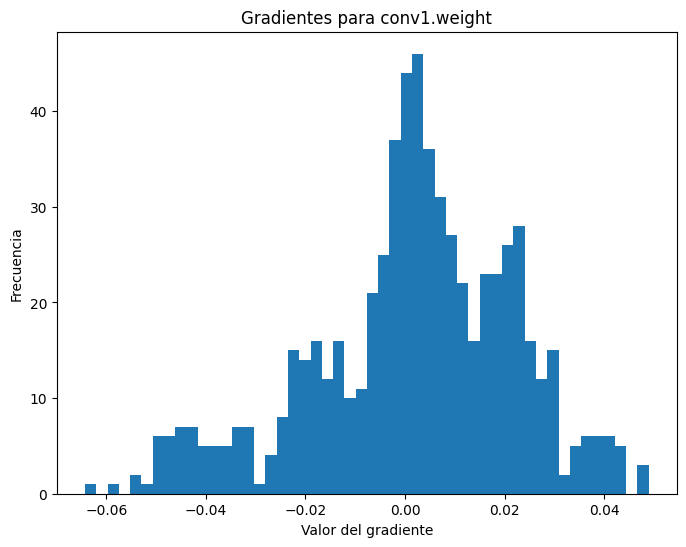

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.007200992200523615, max=0.005434088874608278, mean=-4.426621671882458e-05, std=0.0011689139064401388


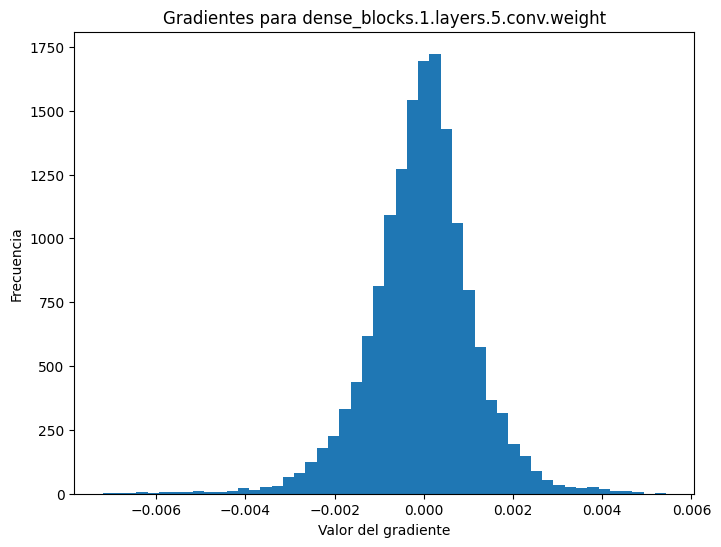

Gradientes para transition_layers.1.conv.weight: min=-0.01716350018978119, max=0.01638423278927803, mean=-0.00019820839224848896, std=0.0023691533133387566


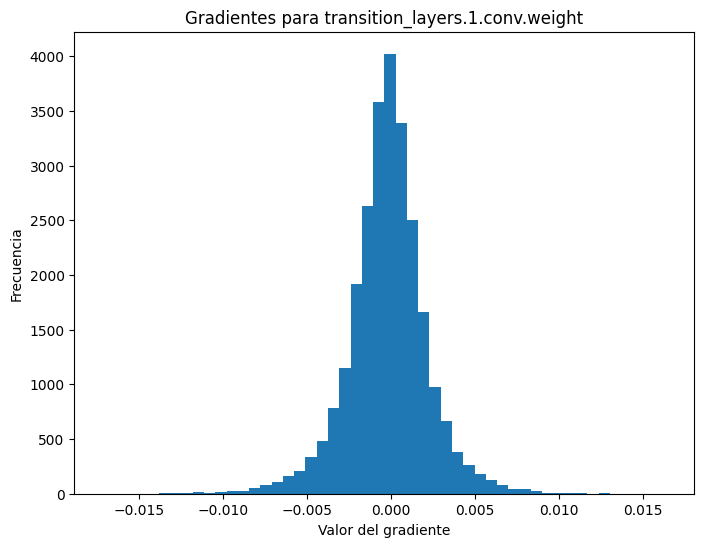

Gradientes para fc.weight: min=-0.034593794494867325, max=0.053628288209438324, mean=-1.848206032661892e-10, std=0.01206493191421032


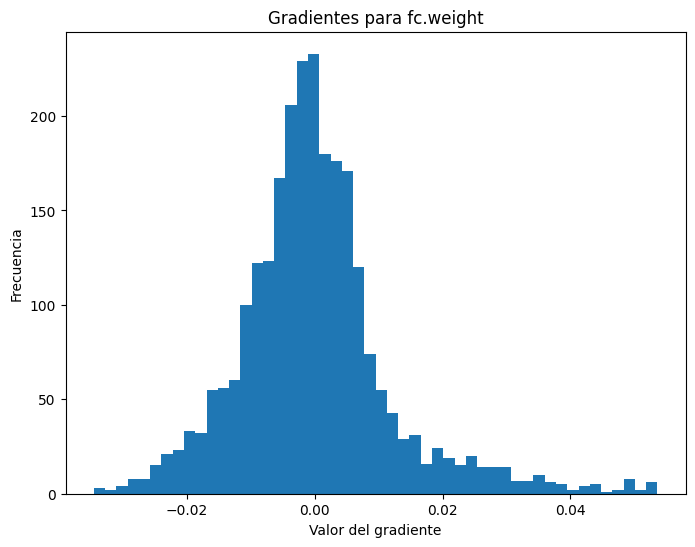

0.1
Epoch 2/70
Iteración 387 - Lote 35/352 - Pérdida de Entrenamiento: 1.2779, Precisión de Entrenamiento: 0.5364
Iteración 422 - Lote 70/352 - Pérdida de Entrenamiento: 1.2587, Precisión de Entrenamiento: 0.5435
Iteración 457 - Lote 105/352 - Pérdida de Entrenamiento: 1.2469, Precisión de Entrenamiento: 0.5438
Iteración 492 - Lote 140/352 - Pérdida de Entrenamiento: 1.2230, Precisión de Entrenamiento: 0.5532
Iteración 527 - Lote 175/352 - Pérdida de Entrenamiento: 1.2019, Precisión de Entrenamiento: 0.5633
Iteración 562 - Lote 210/352 - Pérdida de Entrenamiento: 1.1834, Precisión de Entrenamiento: 0.5712
Iteración 597 - Lote 245/352 - Pérdida de Entrenamiento: 1.1658, Precisión de Entrenamiento: 0.5779
Iteración 632 - Lote 280/352 - Pérdida de Entrenamiento: 1.1473, Precisión de Entrenamiento: 0.5845
Iteración 667 - Lote 315/352 - Pérdida de Entrenamiento: 1.1332, Precisión de Entrenamiento: 0.5899
Iteración 702 - Lote 350/352 - Pérdida de Entrenamiento: 1.1202, Precisión de Entrenami

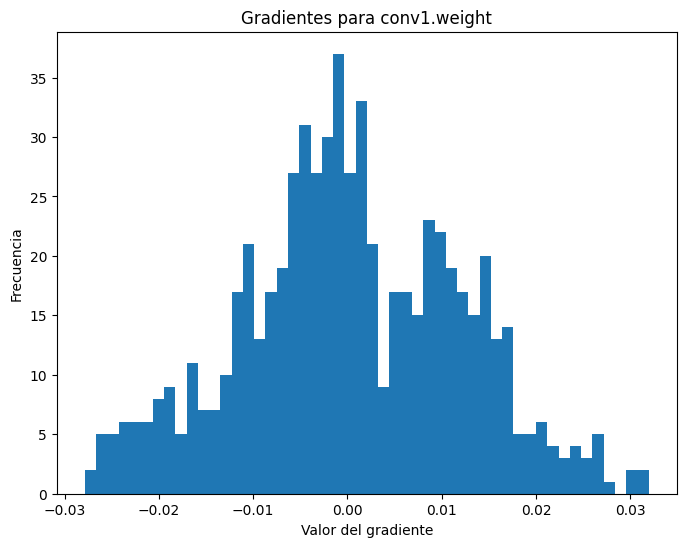

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0076012578792870045, max=0.007384593598544598, mean=2.2654261556454003e-05, std=0.0015183883951976895


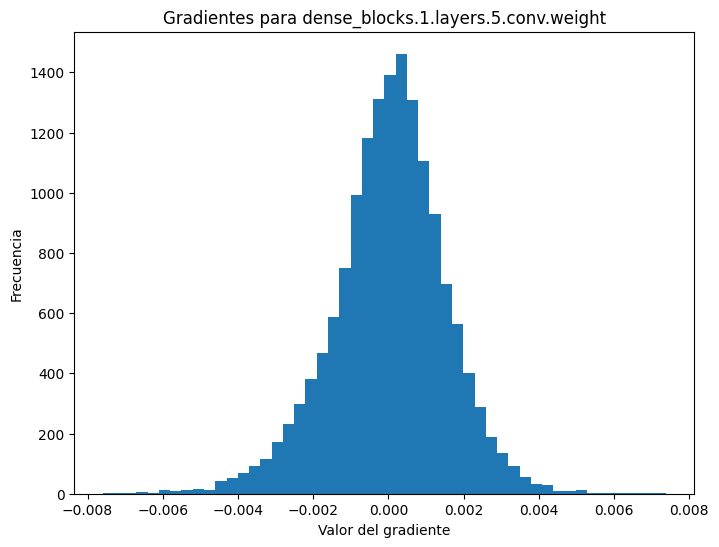

Gradientes para transition_layers.1.conv.weight: min=-0.017910266295075417, max=0.01618192158639431, mean=-9.569324902258813e-05, std=0.0026671888772398233


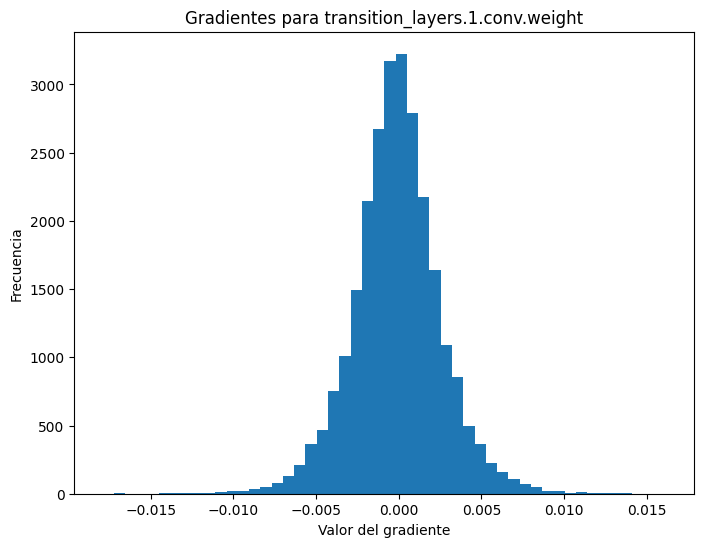

Gradientes para fc.weight: min=-0.025685058906674385, max=0.02005584165453911, mean=2.772309048992838e-10, std=0.004975321236997843


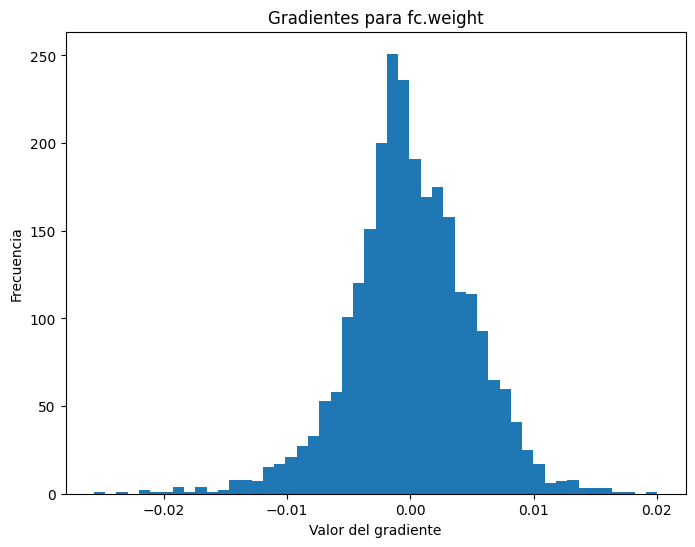

0.1
Epoch 6/70
Iteración 1795 - Lote 35/352 - Pérdida de Entrenamiento: 0.6145, Precisión de Entrenamiento: 0.7893
Iteración 1830 - Lote 70/352 - Pérdida de Entrenamiento: 0.6157, Precisión de Entrenamiento: 0.7869
Iteración 1865 - Lote 105/352 - Pérdida de Entrenamiento: 0.6104, Precisión de Entrenamiento: 0.7905
Iteración 1900 - Lote 140/352 - Pérdida de Entrenamiento: 0.6039, Precisión de Entrenamiento: 0.7927
Iteración 1935 - Lote 175/352 - Pérdida de Entrenamiento: 0.6071, Precisión de Entrenamiento: 0.7913
Iteración 1970 - Lote 210/352 - Pérdida de Entrenamiento: 0.6025, Precisión de Entrenamiento: 0.7913
Iteración 2005 - Lote 245/352 - Pérdida de Entrenamiento: 0.6035, Precisión de Entrenamiento: 0.7903
Iteración 2040 - Lote 280/352 - Pérdida de Entrenamiento: 0.6018, Precisión de Entrenamiento: 0.7914
Iteración 2075 - Lote 315/352 - Pérdida de Entrenamiento: 0.5987, Precisión de Entrenamiento: 0.7925
Iteración 2110 - Lote 350/352 - Pérdida de Entrenamiento: 0.5987, Precisión de

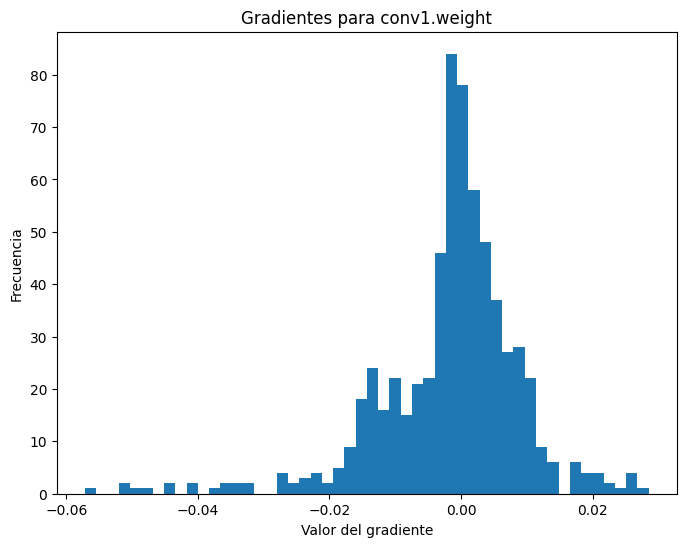

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.009799161925911903, max=0.007819916121661663, mean=-7.039324555080384e-05, std=0.0015803808346390724


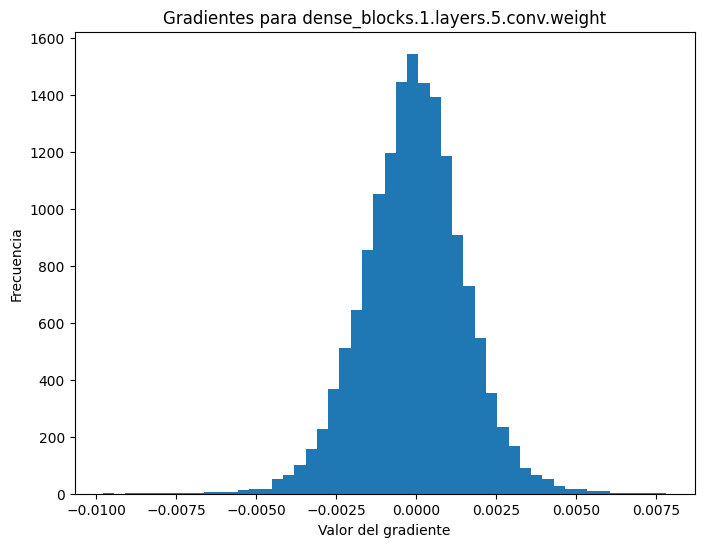

Gradientes para transition_layers.1.conv.weight: min=-0.01980852708220482, max=0.015390285290777683, mean=6.54375835438259e-05, std=0.002674486953765154


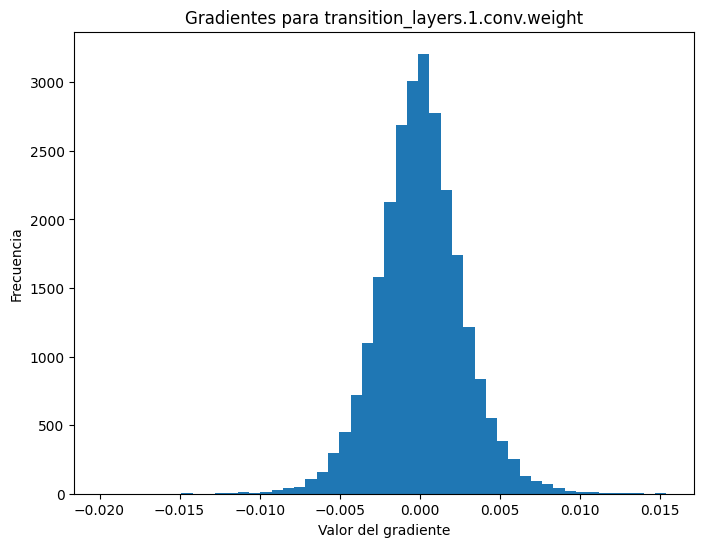

Gradientes para fc.weight: min=-0.0483151376247406, max=0.03287675231695175, mean=4.62051508165473e-11, std=0.007284794468432665


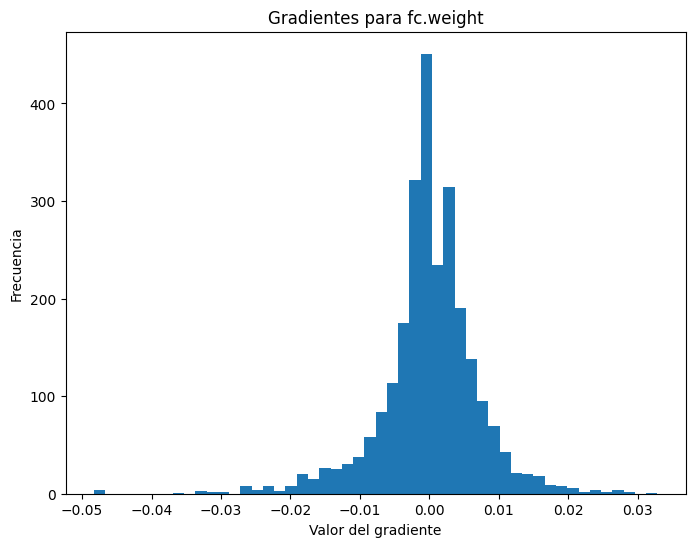

0.1
Epoch 11/70
Iteración 3555 - Lote 35/352 - Pérdida de Entrenamiento: 0.3902, Precisión de Entrenamiento: 0.8663
Iteración 3590 - Lote 70/352 - Pérdida de Entrenamiento: 0.3992, Precisión de Entrenamiento: 0.8616
Iteración 3625 - Lote 105/352 - Pérdida de Entrenamiento: 0.4002, Precisión de Entrenamiento: 0.8604
Iteración 3660 - Lote 140/352 - Pérdida de Entrenamiento: 0.4021, Precisión de Entrenamiento: 0.8594
Iteración 3695 - Lote 175/352 - Pérdida de Entrenamiento: 0.3964, Precisión de Entrenamiento: 0.8629
Iteración 3730 - Lote 210/352 - Pérdida de Entrenamiento: 0.3987, Precisión de Entrenamiento: 0.8617
Iteración 3765 - Lote 245/352 - Pérdida de Entrenamiento: 0.4019, Precisión de Entrenamiento: 0.8603
Iteración 3800 - Lote 280/352 - Pérdida de Entrenamiento: 0.4021, Precisión de Entrenamiento: 0.8607
Iteración 3835 - Lote 315/352 - Pérdida de Entrenamiento: 0.4040, Precisión de Entrenamiento: 0.8602
Iteración 3870 - Lote 350/352 - Pérdida de Entrenamiento: 0.4045, Precisión d

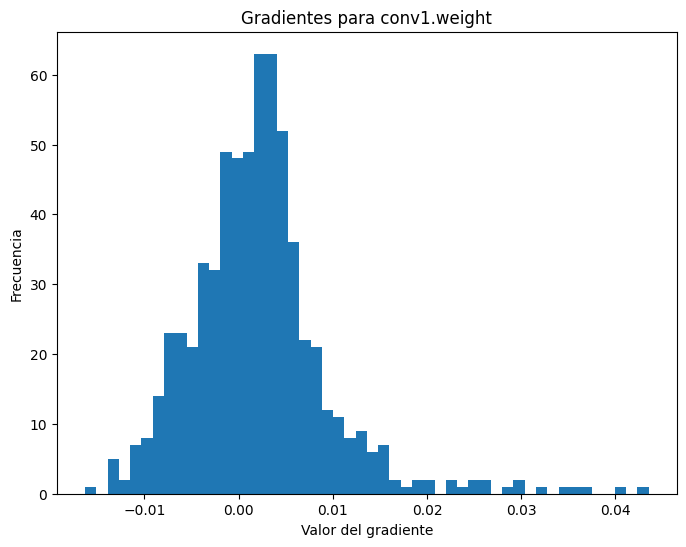

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0066682021133601665, max=0.006051016505807638, mean=-3.943666160921566e-05, std=0.0011730404803529382


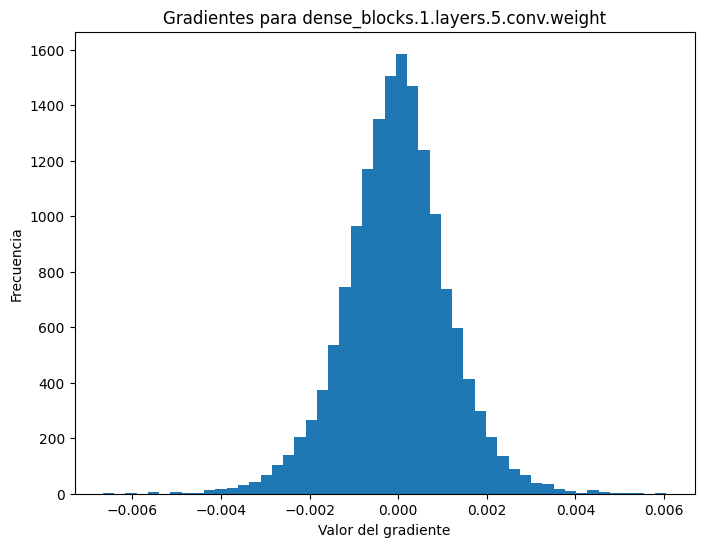

Gradientes para transition_layers.1.conv.weight: min=-0.016979949548840523, max=0.014754299074411392, mean=-2.0935218344675377e-05, std=0.0020476579666137695


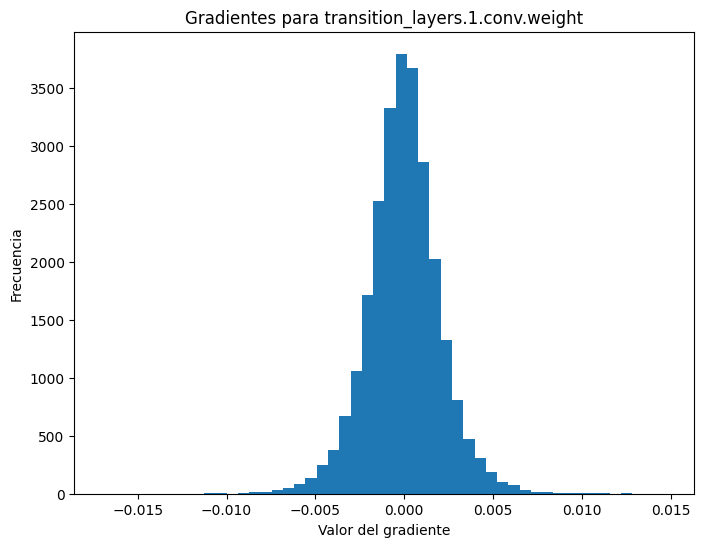

Gradientes para fc.weight: min=-0.025472573935985565, max=0.02285877987742424, mean=0.0, std=0.0037204765249043703


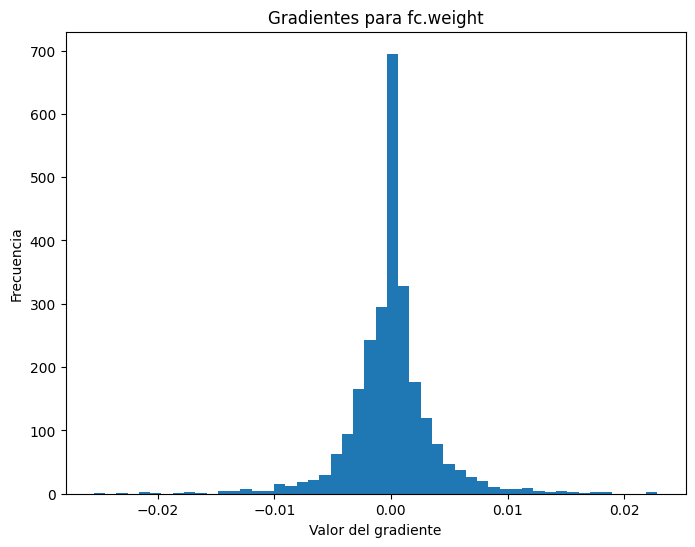

0.1
Epoch 16/70
Iteración 5315 - Lote 35/352 - Pérdida de Entrenamiento: 0.2912, Precisión de Entrenamiento: 0.8982
Iteración 5350 - Lote 70/352 - Pérdida de Entrenamiento: 0.2953, Precisión de Entrenamiento: 0.8973
Iteración 5385 - Lote 105/352 - Pérdida de Entrenamiento: 0.2987, Precisión de Entrenamiento: 0.8963
Iteración 5420 - Lote 140/352 - Pérdida de Entrenamiento: 0.2973, Precisión de Entrenamiento: 0.8960
Iteración 5455 - Lote 175/352 - Pérdida de Entrenamiento: 0.2992, Precisión de Entrenamiento: 0.8958
Iteración 5490 - Lote 210/352 - Pérdida de Entrenamiento: 0.2959, Precisión de Entrenamiento: 0.8962
Iteración 5525 - Lote 245/352 - Pérdida de Entrenamiento: 0.2969, Precisión de Entrenamiento: 0.8962
Iteración 5560 - Lote 280/352 - Pérdida de Entrenamiento: 0.3023, Precisión de Entrenamiento: 0.8944
Iteración 5595 - Lote 315/352 - Pérdida de Entrenamiento: 0.3041, Precisión de Entrenamiento: 0.8937
Iteración 5630 - Lote 350/352 - Pérdida de Entrenamiento: 0.3073, Precisión d

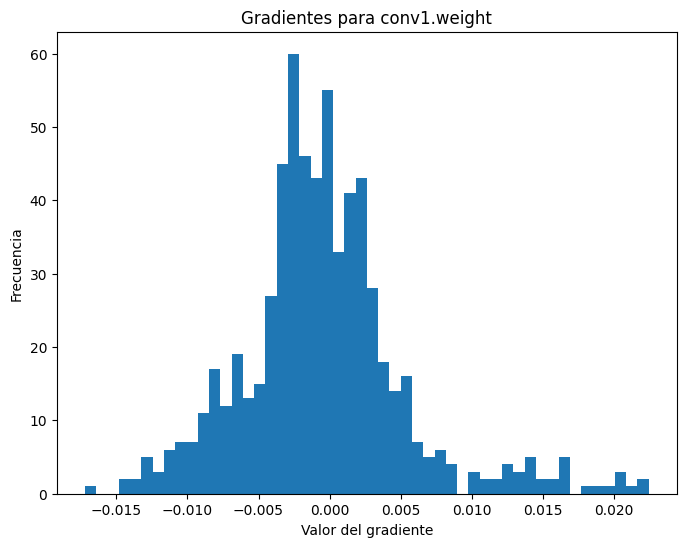

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0073505244217813015, max=0.006891184486448765, mean=3.570526678231545e-05, std=0.0012810149928554893


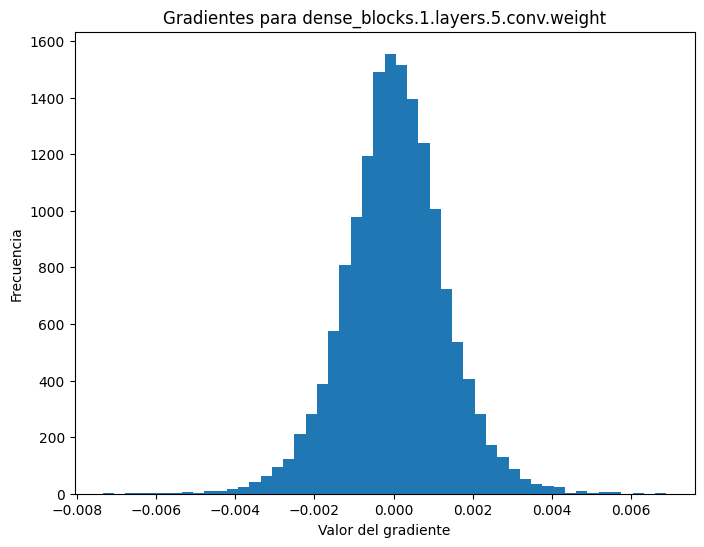

Gradientes para transition_layers.1.conv.weight: min=-0.012975964695215225, max=0.014430741779506207, mean=1.0991043382091448e-05, std=0.0021642420906573534


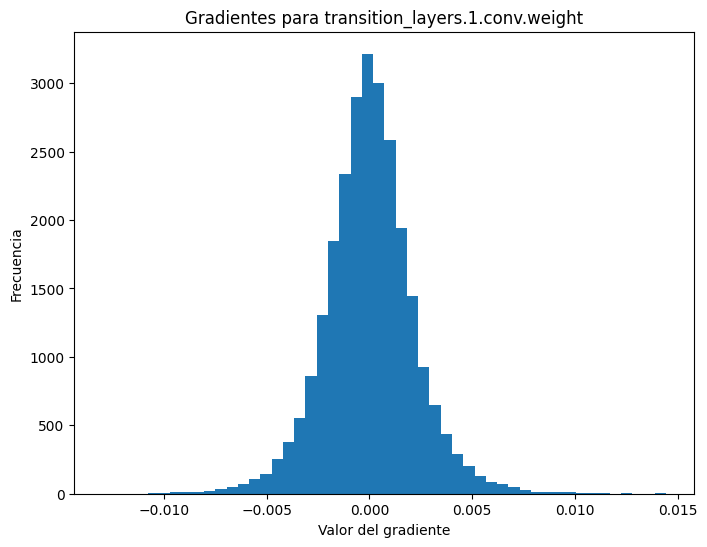

Gradientes para fc.weight: min=-0.018145011737942696, max=0.018090561032295227, mean=9.24103016330946e-11, std=0.002723958343267441


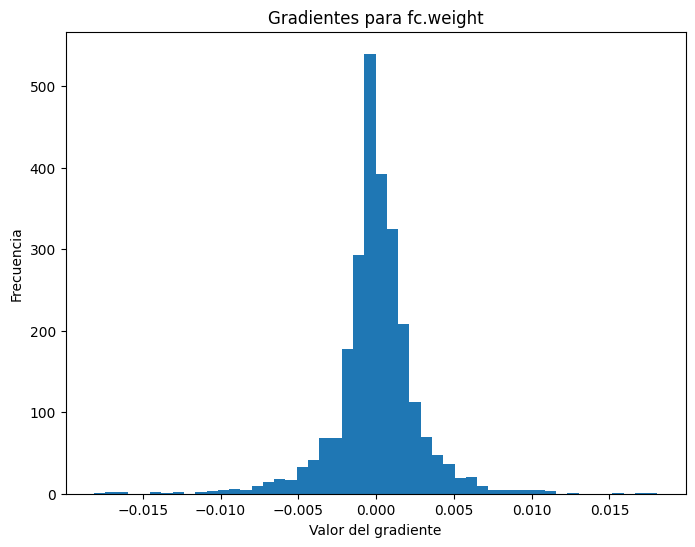

0.1
Epoch 21/70
Iteración 7075 - Lote 35/352 - Pérdida de Entrenamiento: 0.2601, Precisión de Entrenamiento: 0.9071
Iteración 7110 - Lote 70/352 - Pérdida de Entrenamiento: 0.2537, Precisión de Entrenamiento: 0.9096
Iteración 7145 - Lote 105/352 - Pérdida de Entrenamiento: 0.2534, Precisión de Entrenamiento: 0.9106
Iteración 7180 - Lote 140/352 - Pérdida de Entrenamiento: 0.2473, Precisión de Entrenamiento: 0.9132
Iteración 7215 - Lote 175/352 - Pérdida de Entrenamiento: 0.2467, Precisión de Entrenamiento: 0.9144
Iteración 7250 - Lote 210/352 - Pérdida de Entrenamiento: 0.2460, Precisión de Entrenamiento: 0.9151
Iteración 7285 - Lote 245/352 - Pérdida de Entrenamiento: 0.2470, Precisión de Entrenamiento: 0.9147
Iteración 7320 - Lote 280/352 - Pérdida de Entrenamiento: 0.2470, Precisión de Entrenamiento: 0.9146
Iteración 7355 - Lote 315/352 - Pérdida de Entrenamiento: 0.2454, Precisión de Entrenamiento: 0.9152
Iteración 7390 - Lote 350/352 - Pérdida de Entrenamiento: 0.2473, Precisión d

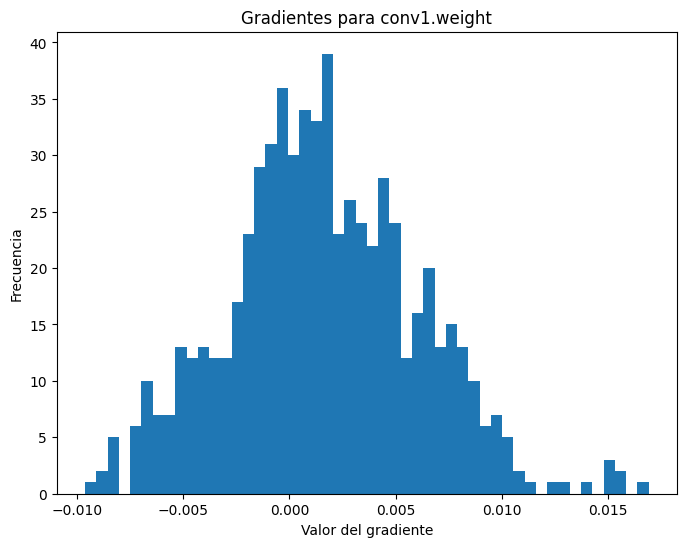

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.004975687246769667, max=0.005443415604531765, mean=-7.775522681185976e-05, std=0.0009141410700976849


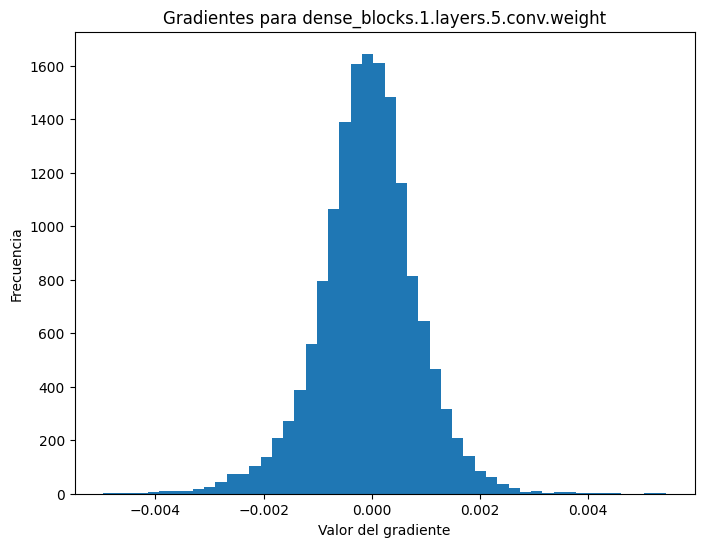

Gradientes para transition_layers.1.conv.weight: min=-0.013783585280179977, max=0.012426457367837429, mean=-1.3274230923343566e-06, std=0.0016341671580448747


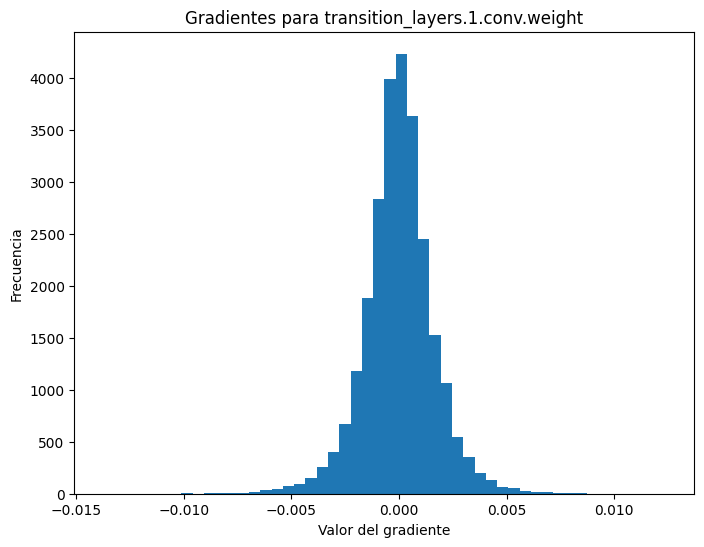

Gradientes para fc.weight: min=-0.03234811872243881, max=0.03290088102221489, mean=9.24103016330946e-11, std=0.002781776012852788


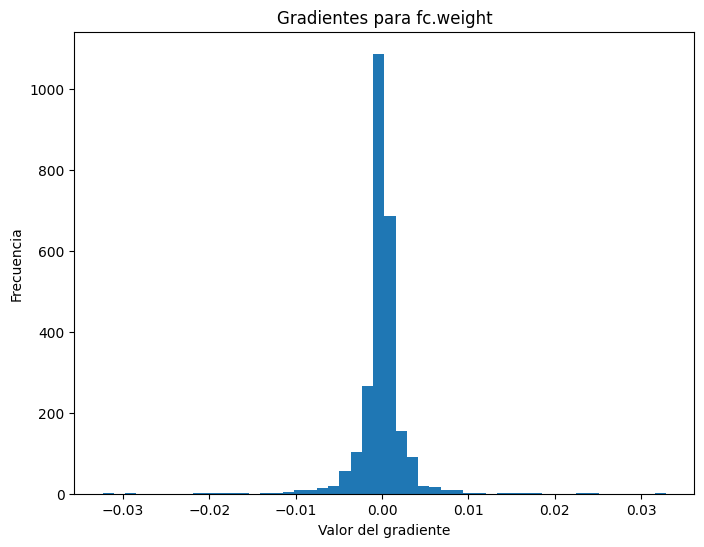

0.1
Epoch 26/70
Iteración 8835 - Lote 35/352 - Pérdida de Entrenamiento: 0.1763, Precisión de Entrenamiento: 0.9406
Iteración 8870 - Lote 70/352 - Pérdida de Entrenamiento: 0.1854, Precisión de Entrenamiento: 0.9350
Iteración 8905 - Lote 105/352 - Pérdida de Entrenamiento: 0.1815, Precisión de Entrenamiento: 0.9350
Iteración 8940 - Lote 140/352 - Pérdida de Entrenamiento: 0.1918, Precisión de Entrenamiento: 0.9320
Iteración 8975 - Lote 175/352 - Pérdida de Entrenamiento: 0.1918, Precisión de Entrenamiento: 0.9317
Iteración 9010 - Lote 210/352 - Pérdida de Entrenamiento: 0.1931, Precisión de Entrenamiento: 0.9318
Iteración 9045 - Lote 245/352 - Pérdida de Entrenamiento: 0.1934, Precisión de Entrenamiento: 0.9318
Iteración 9080 - Lote 280/352 - Pérdida de Entrenamiento: 0.1968, Precisión de Entrenamiento: 0.9303
Iteración 9115 - Lote 315/352 - Pérdida de Entrenamiento: 0.1969, Precisión de Entrenamiento: 0.9310
Iteración 9150 - Lote 350/352 - Pérdida de Entrenamiento: 0.1982, Precisión d

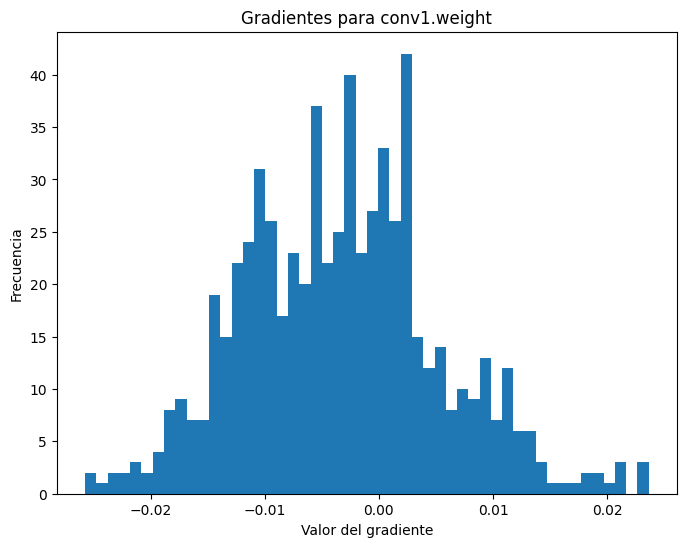

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.007667166646569967, max=0.008438528515398502, mean=2.1198654565068864e-07, std=0.001533879549242556


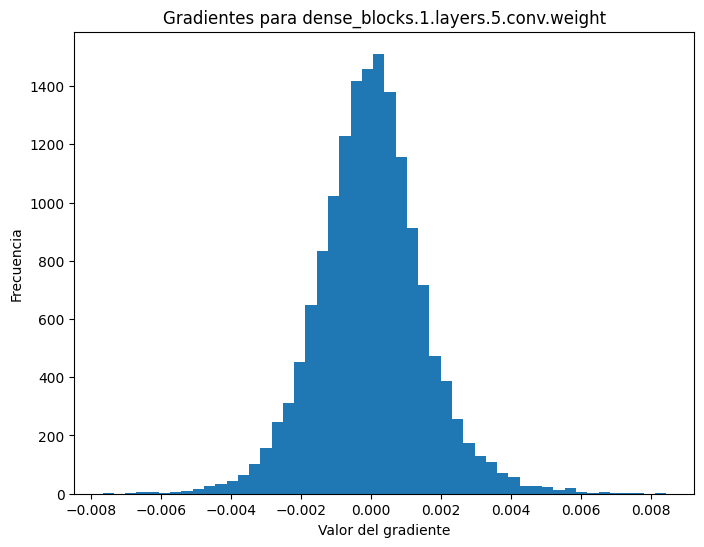

Gradientes para transition_layers.1.conv.weight: min=-0.017981037497520447, max=0.016809390857815742, mean=1.2132662050134968e-05, std=0.00246013468131423


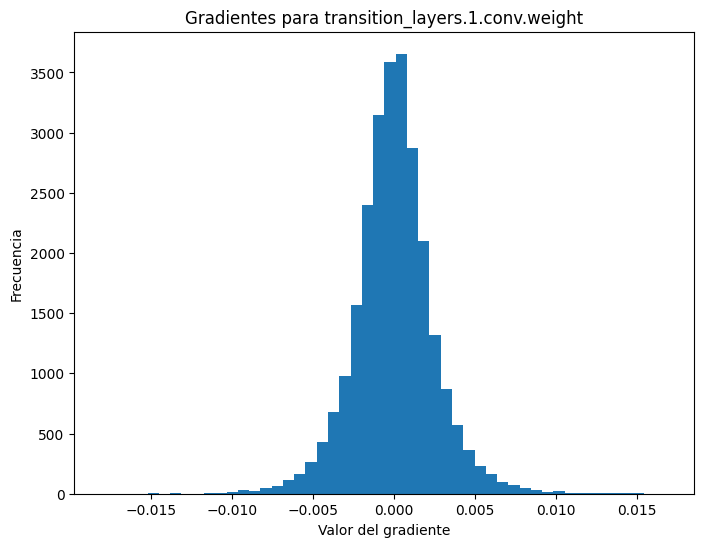

Gradientes para fc.weight: min=-0.03945484012365341, max=0.028656616806983948, mean=1.386154524496419e-10, std=0.004517415538430214


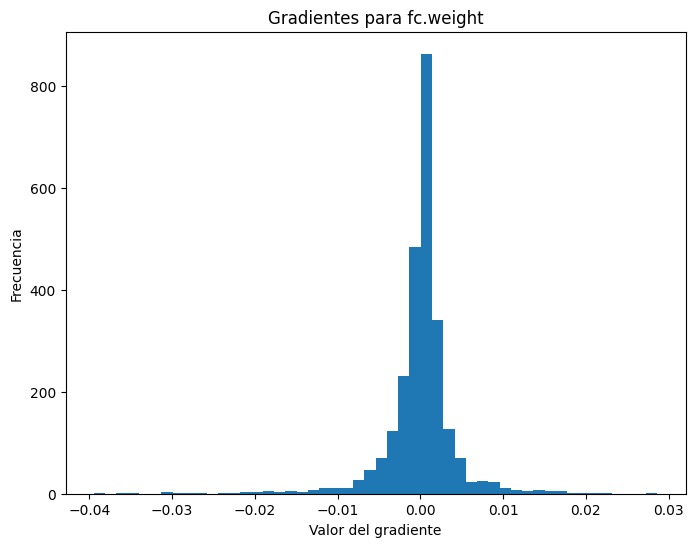

0.1
Epoch 31/70
Iteración 10595 - Lote 35/352 - Pérdida de Entrenamiento: 0.1541, Precisión de Entrenamiento: 0.9424
Iteración 10630 - Lote 70/352 - Pérdida de Entrenamiento: 0.1517, Precisión de Entrenamiento: 0.9440
Iteración 10665 - Lote 105/352 - Pérdida de Entrenamiento: 0.1564, Precisión de Entrenamiento: 0.9428
Iteración 10700 - Lote 140/352 - Pérdida de Entrenamiento: 0.1601, Precisión de Entrenamiento: 0.9419
Iteración 10735 - Lote 175/352 - Pérdida de Entrenamiento: 0.1621, Precisión de Entrenamiento: 0.9413
Iteración 10770 - Lote 210/352 - Pérdida de Entrenamiento: 0.1640, Precisión de Entrenamiento: 0.9411
Iteración 10805 - Lote 245/352 - Pérdida de Entrenamiento: 0.1635, Precisión de Entrenamiento: 0.9412
Iteración 10840 - Lote 280/352 - Pérdida de Entrenamiento: 0.1657, Precisión de Entrenamiento: 0.9409
Iteración 10875 - Lote 315/352 - Pérdida de Entrenamiento: 0.1706, Precisión de Entrenamiento: 0.9390
Iteración 10910 - Lote 350/352 - Pérdida de Entrenamiento: 0.1711, P

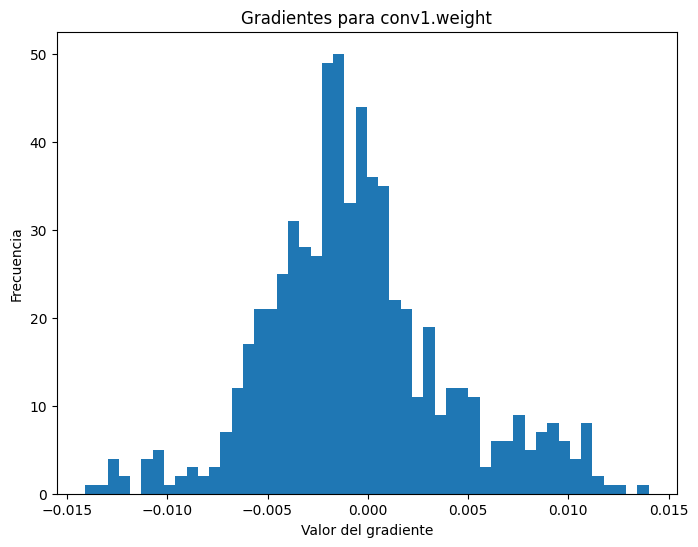

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0059235538356006145, max=0.0033660707995295525, mean=1.4198244571161922e-05, std=0.000762599054723978


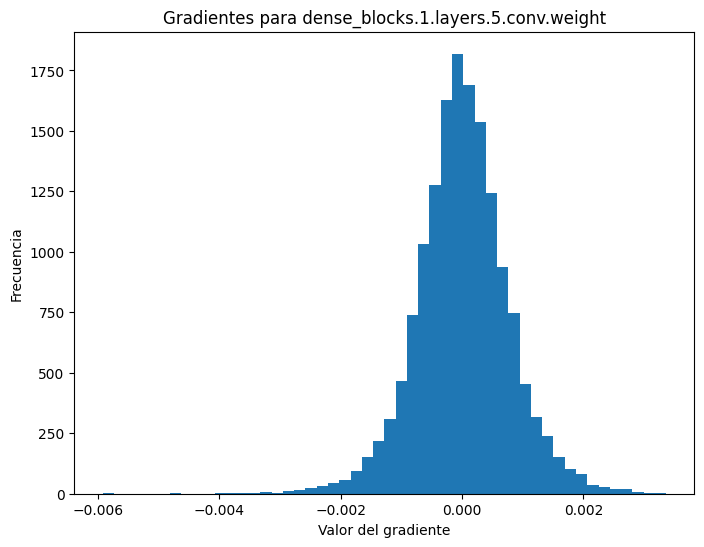

Gradientes para transition_layers.1.conv.weight: min=-0.011747132986783981, max=0.013080492615699768, mean=4.650530627259286e-06, std=0.0014228221261873841


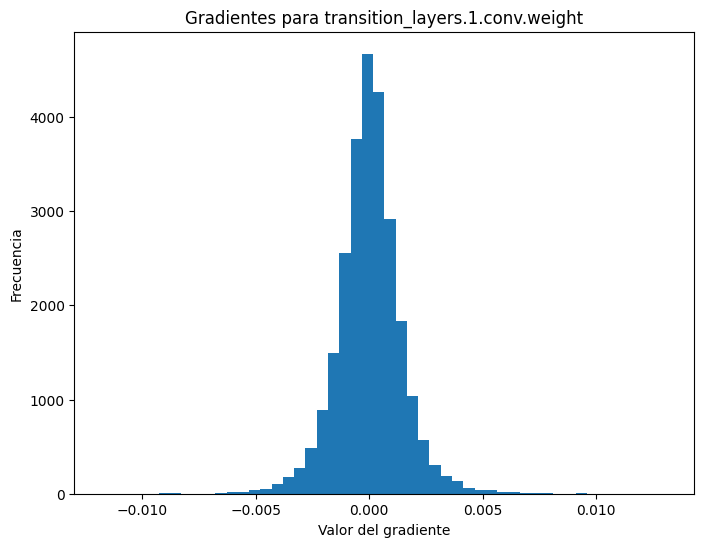

Gradientes para fc.weight: min=-0.012078534811735153, max=0.01295139454305172, mean=3.176604257415505e-10, std=0.0017243893817067146


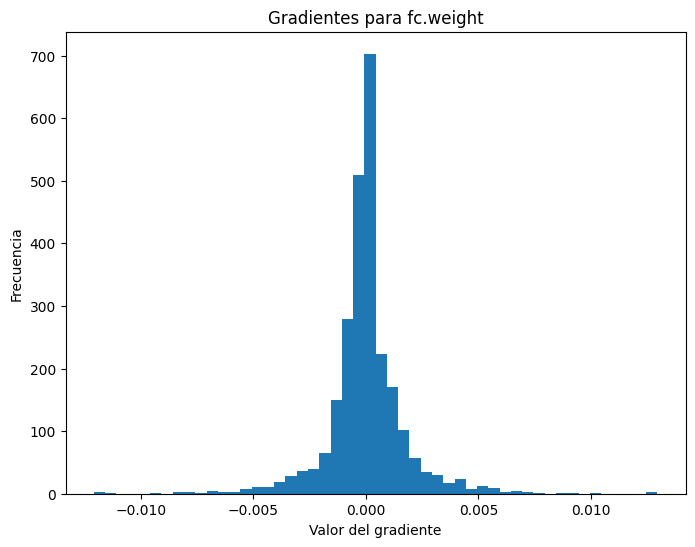

0.010000000000000002
Epoch 36/70
Iteración 12355 - Lote 35/352 - Pérdida de Entrenamiento: 0.0769, Precisión de Entrenamiento: 0.9737
Iteración 12390 - Lote 70/352 - Pérdida de Entrenamiento: 0.0767, Precisión de Entrenamiento: 0.9741
Iteración 12425 - Lote 105/352 - Pérdida de Entrenamiento: 0.0756, Precisión de Entrenamiento: 0.9751
Iteración 12460 - Lote 140/352 - Pérdida de Entrenamiento: 0.0750, Precisión de Entrenamiento: 0.9756
Iteración 12495 - Lote 175/352 - Pérdida de Entrenamiento: 0.0758, Precisión de Entrenamiento: 0.9758
Iteración 12530 - Lote 210/352 - Pérdida de Entrenamiento: 0.0745, Precisión de Entrenamiento: 0.9761
Iteración 12565 - Lote 245/352 - Pérdida de Entrenamiento: 0.0745, Precisión de Entrenamiento: 0.9762
Iteración 12600 - Lote 280/352 - Pérdida de Entrenamiento: 0.0735, Precisión de Entrenamiento: 0.9765
Iteración 12635 - Lote 315/352 - Pérdida de Entrenamiento: 0.0736, Precisión de Entrenamiento: 0.9767
Iteración 12670 - Lote 350/352 - Pérdida de Entrena

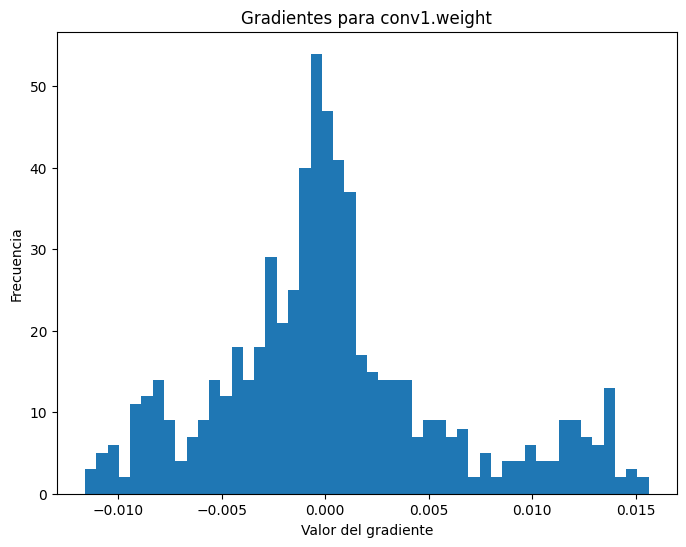

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.00616490887477994, max=0.007341593038290739, mean=-1.7602613297640346e-05, std=0.0009244685643352568


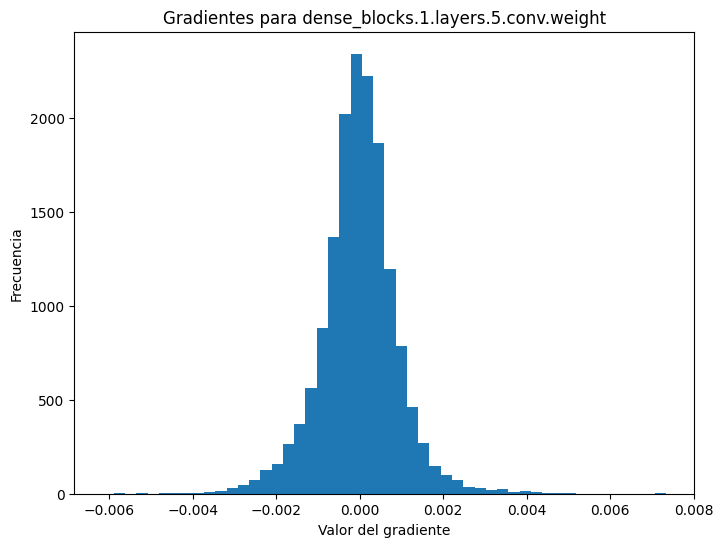

Gradientes para transition_layers.1.conv.weight: min=-0.01907900534570217, max=0.015061888843774796, mean=2.836444582499098e-05, std=0.0015252644661813974


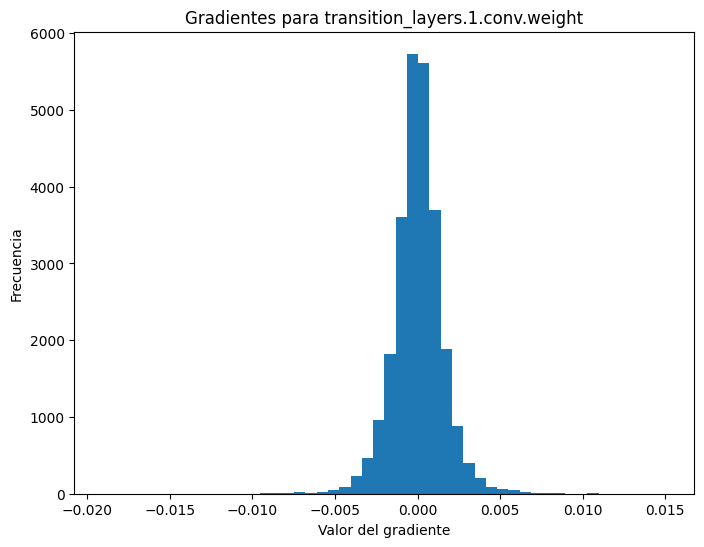

Gradientes para fc.weight: min=-0.01564105600118637, max=0.009033101610839367, mean=2.772309048992838e-10, std=0.0016895447624847293


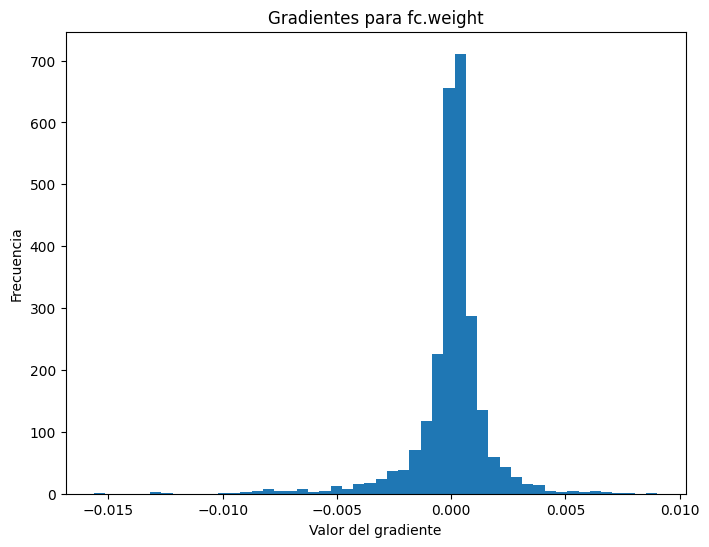

0.010000000000000002
Epoch 41/70
Iteración 14115 - Lote 35/352 - Pérdida de Entrenamiento: 0.0483, Precisión de Entrenamiento: 0.9868
Iteración 14150 - Lote 70/352 - Pérdida de Entrenamiento: 0.0523, Precisión de Entrenamiento: 0.9845
Iteración 14185 - Lote 105/352 - Pérdida de Entrenamiento: 0.0553, Precisión de Entrenamiento: 0.9832
Iteración 14220 - Lote 140/352 - Pérdida de Entrenamiento: 0.0559, Precisión de Entrenamiento: 0.9828
Iteración 14255 - Lote 175/352 - Pérdida de Entrenamiento: 0.0549, Precisión de Entrenamiento: 0.9829
Iteración 14290 - Lote 210/352 - Pérdida de Entrenamiento: 0.0558, Precisión de Entrenamiento: 0.9829
Iteración 14325 - Lote 245/352 - Pérdida de Entrenamiento: 0.0558, Precisión de Entrenamiento: 0.9827
Iteración 14360 - Lote 280/352 - Pérdida de Entrenamiento: 0.0566, Precisión de Entrenamiento: 0.9821
Iteración 14395 - Lote 315/352 - Pérdida de Entrenamiento: 0.0562, Precisión de Entrenamiento: 0.9820
Iteración 14430 - Lote 350/352 - Pérdida de Entrena

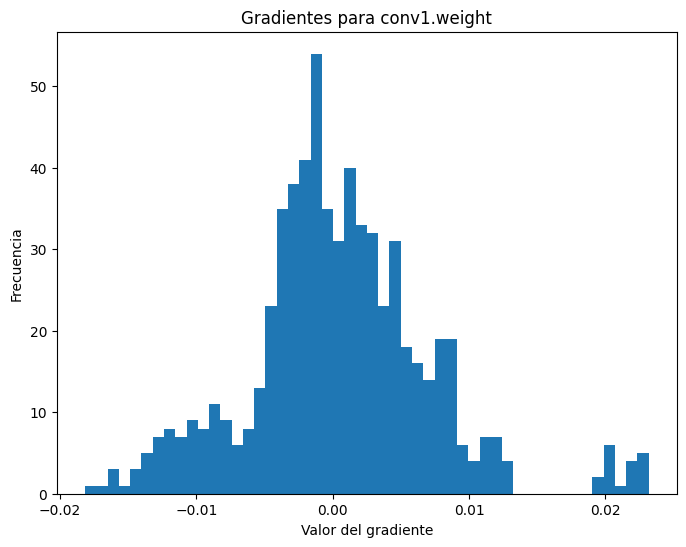

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.004486564081162214, max=0.004807275254279375, mean=7.66566809033975e-05, std=0.0008462793775834143


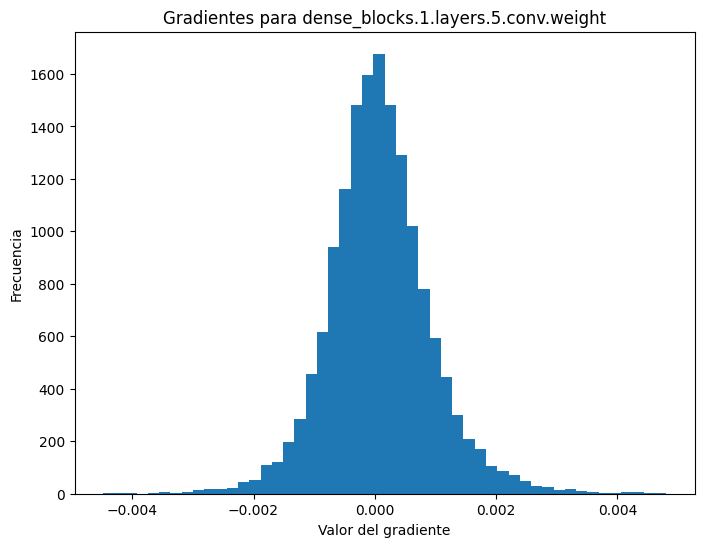

Gradientes para transition_layers.1.conv.weight: min=-0.02619791217148304, max=0.01731260120868683, mean=2.0688325093942694e-05, std=0.0015047984197735786


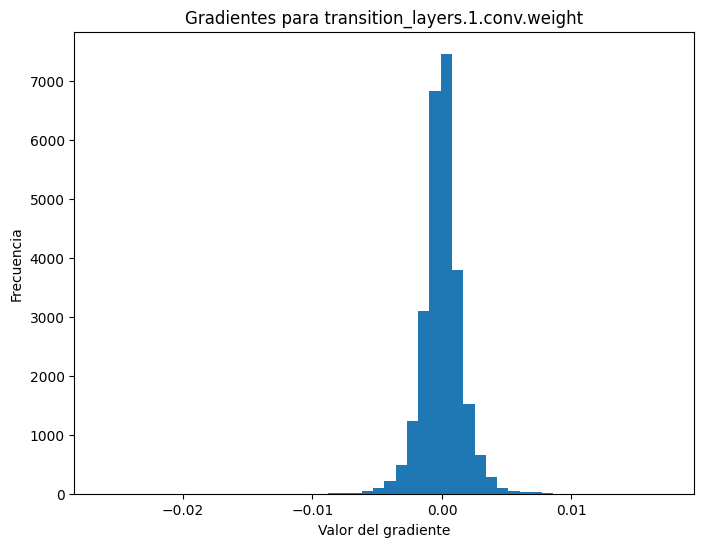

Gradientes para fc.weight: min=-0.014754577539861202, max=0.014944685623049736, mean=4.62051508165473e-11, std=0.001651215716265142


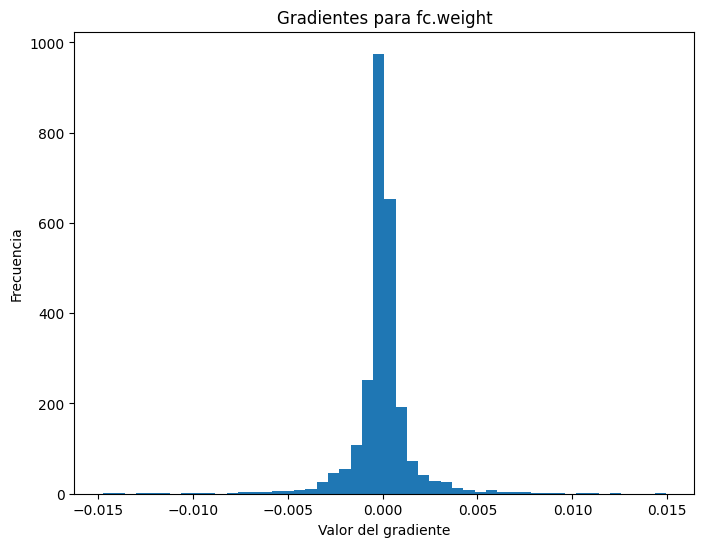

0.0010000000000000002
Epoch 46/70
Iteración 15875 - Lote 35/352 - Pérdida de Entrenamiento: 0.0465, Precisión de Entrenamiento: 0.9857
Iteración 15910 - Lote 70/352 - Pérdida de Entrenamiento: 0.0455, Precisión de Entrenamiento: 0.9846
Iteración 15945 - Lote 105/352 - Pérdida de Entrenamiento: 0.0467, Precisión de Entrenamiento: 0.9842
Iteración 15980 - Lote 140/352 - Pérdida de Entrenamiento: 0.0459, Precisión de Entrenamiento: 0.9845
Iteración 16015 - Lote 175/352 - Pérdida de Entrenamiento: 0.0465, Precisión de Entrenamiento: 0.9847
Iteración 16050 - Lote 210/352 - Pérdida de Entrenamiento: 0.0471, Precisión de Entrenamiento: 0.9844
Iteración 16085 - Lote 245/352 - Pérdida de Entrenamiento: 0.0476, Precisión de Entrenamiento: 0.9844
Iteración 16120 - Lote 280/352 - Pérdida de Entrenamiento: 0.0476, Precisión de Entrenamiento: 0.9845
Iteración 16155 - Lote 315/352 - Pérdida de Entrenamiento: 0.0477, Precisión de Entrenamiento: 0.9846
Iteración 16190 - Lote 350/352 - Pérdida de Entren

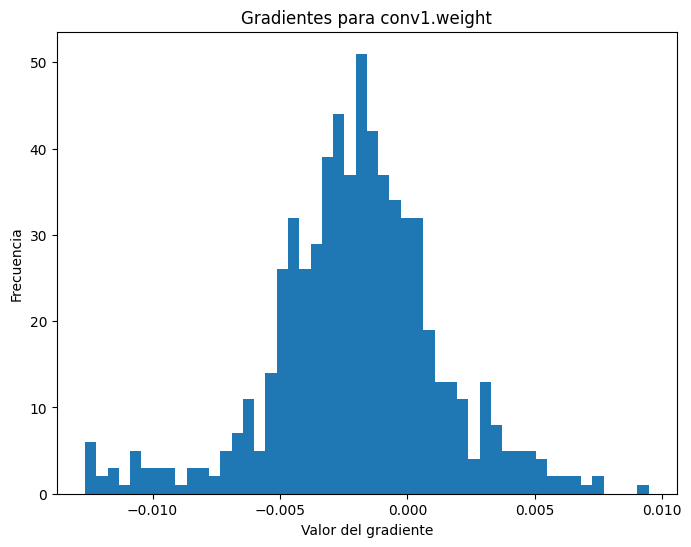

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.004765003453940153, max=0.004776559770107269, mean=-4.0433587855659425e-05, std=0.0008791048894636333


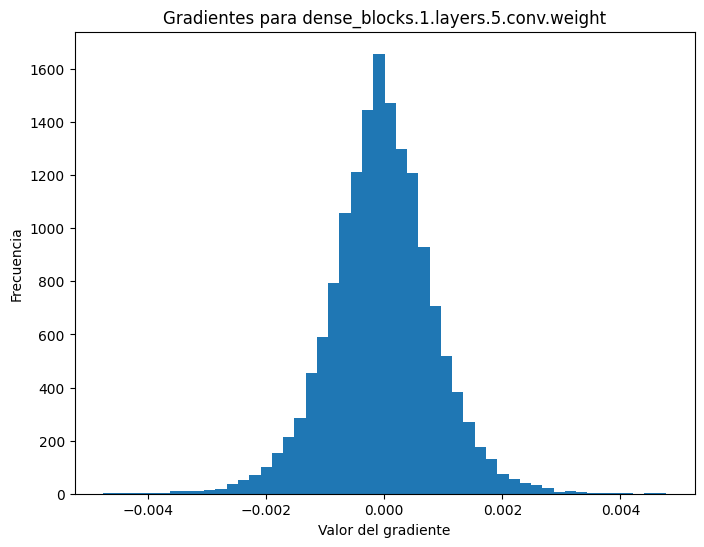

Gradientes para transition_layers.1.conv.weight: min=-0.01539266761392355, max=0.018986204639077187, mean=2.2688080207444727e-05, std=0.0013008571695536375


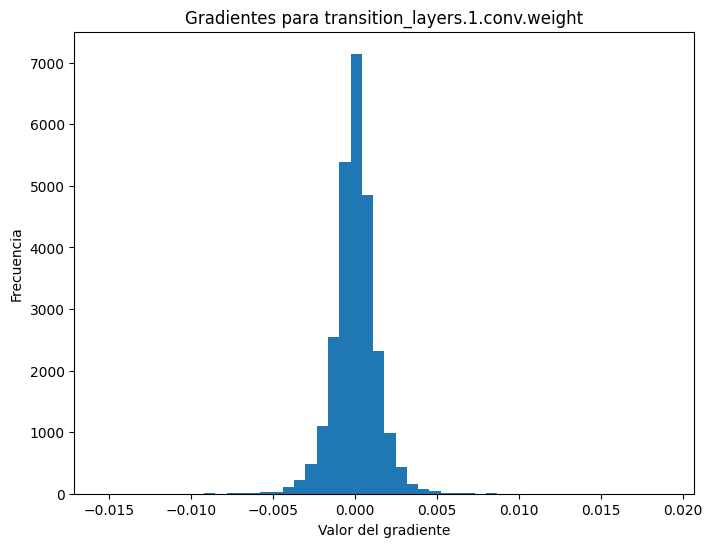

Gradientes para fc.weight: min=-0.01651218719780445, max=0.012124336324632168, mean=0.0, std=0.0017310265684500337


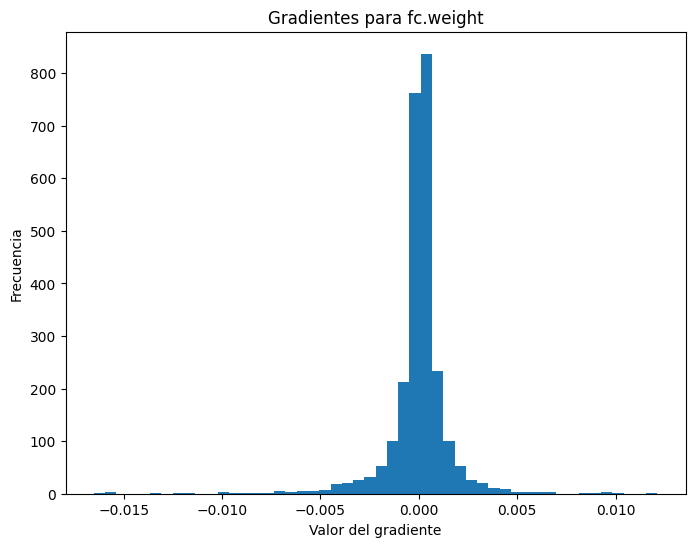

Early stopping at epoch 50

Tiempo total de entrenamiento: 3891.31 segundos


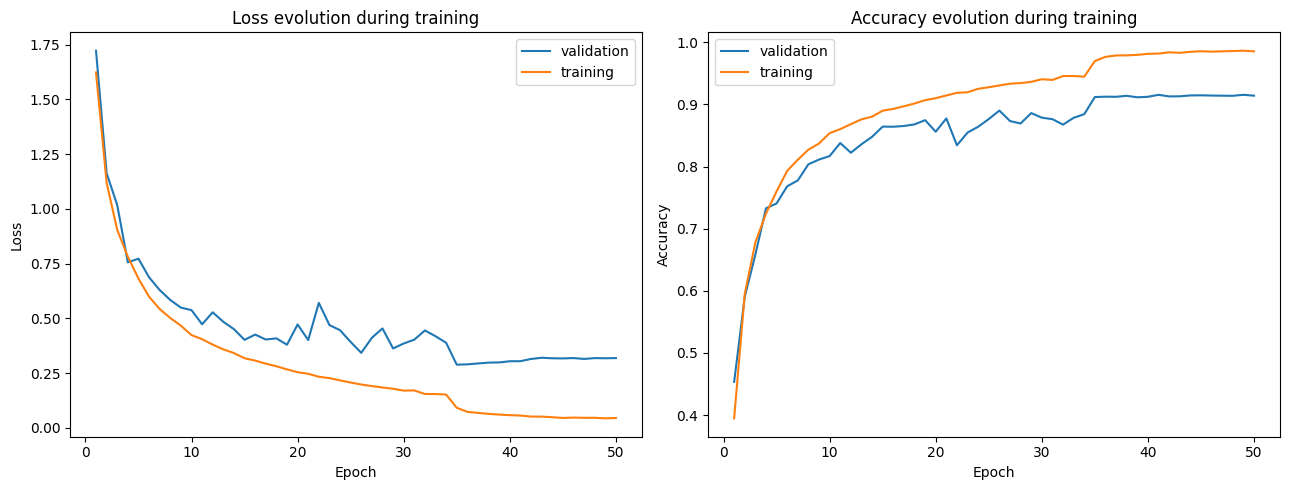

In [ ]:
use_gpu = True

# Checkpointing functions
checkpoint_dir = "/content/drive/MyDrive/CheckpointsDenseNet40"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 70
    max_iterations = 600000  # Ajusta según sea necesario
    learning_rate = 0.1
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-5
    early_stop_thresh = 15
    patience = 7

    # Inicializar el modelo
    model = DenseNet40(growth_rate=12, num_layers=40, reduction=0.5, num_classes=10)

    print(model)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    curves = train_model(
        model=model,
        train_dataset=train_cifar10,
        val_dataset=val_cifar10,
        epochs=epochs,
        max_iterations=max_iterations,
        criterion=criterion,
        batch_size=batch_size,
        lr=learning_rate,
        n_evaluations_per_epoch=n_evaluations_per_epoch,
        early_stop_thresh=early_stop_thresh,
        show_gradients=show_gradients_DenseNet,
        patience=patience,
        use_gpu=use_gpu,
        data_augmentation=data_augmentation,
        resume_checkpoint=None,  # Establece a una cadena de caracteres para reanudar, por ejemplo, "best_checkpoint_epoch_10.pth"
        weight_decay=weight_decay
    )

    # Plotear curvas de entrenamiento
    show_curves(curves)

In [ ]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/CheckpointsDenseNet40"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

# Crear una instancia del modelo
model = DenseNet40(growth_rate=12, num_layers=40, reduction=0.5, num_classes=10)

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Preparar el conjunto de prueba y el DataLoader

# Crear el DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    test_cifar10,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1,5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1,5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")


Mejor modelo encontrado: best_checkpoint_epoch_35.pth


<ipython-input-5-77eda45daf6d>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.10/dist

Precisión TOP1 en el conjunto de prueba: 90.28%
Precisión TOP5 en el conjunto de prueba: 99.71%


# DenseNet 67
k = 12


In [ ]:
# Dense Layer
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], 1)  # Concatenate input with output

# Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            DenseLayer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

# DenseNet Model
class DenseNet67(nn.Module):
    def __init__(self, growth_rate=12, num_layers=67, reduction=0.5, num_classes=10):
        super(DenseNet67, self).__init__()
        assert (num_layers - 4) % 3 == 0, "Number of layers must be 3N + 4"
        num_blocks = 3
        num_layers_per_block = (num_layers - 4) // num_blocks

        self.growth_rate = growth_rate
        num_channels = 2 * growth_rate  # Initial number of channels

        # Initial Convolution
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # Dense Blocks with Transition Layers
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()
        for i in range(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers_per_block, num_channels, growth_rate))
            num_channels += num_layers_per_block * growth_rate
            if i != num_blocks - 1:  # Add transition layer between blocks
                out_channels = int(num_channels * reduction)
                self.transition_layers.append(TransitionLayer(num_channels, out_channels))
                num_channels = out_channels

        # Final BatchNorm and Fully Connected Layer
        self.bn = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        for i, dense_block in enumerate(self.dense_blocks):
            x = dense_block(x)
            if i < len(self.transition_layers):
                x = self.transition_layers[i](x)
        x = F.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the DenseNet-67 model
model = DenseNet67(growth_rate=12, num_layers=67, reduction=0.5, num_classes=10)

In [ ]:
def densenet67():
    # Crear la DenseNet-40 con los parámetros especificados
    return DenseNet67(growth_rate=12, num_layers=67, reduction=0.5, num_classes=10)

# Instanciar el modelo
model = densenet67()

# Mostrar las capas del modelo
for name, param in model.named_parameters():
    print(name)

conv1.weight
dense_blocks.0.layers.0.bn.weight
dense_blocks.0.layers.0.bn.bias
dense_blocks.0.layers.0.conv.weight
dense_blocks.0.layers.1.bn.weight
dense_blocks.0.layers.1.bn.bias
dense_blocks.0.layers.1.conv.weight
dense_blocks.0.layers.2.bn.weight
dense_blocks.0.layers.2.bn.bias
dense_blocks.0.layers.2.conv.weight
dense_blocks.0.layers.3.bn.weight
dense_blocks.0.layers.3.bn.bias
dense_blocks.0.layers.3.conv.weight
dense_blocks.0.layers.4.bn.weight
dense_blocks.0.layers.4.bn.bias
dense_blocks.0.layers.4.conv.weight
dense_blocks.0.layers.5.bn.weight
dense_blocks.0.layers.5.bn.bias
dense_blocks.0.layers.5.conv.weight
dense_blocks.0.layers.6.bn.weight
dense_blocks.0.layers.6.bn.bias
dense_blocks.0.layers.6.conv.weight
dense_blocks.0.layers.7.bn.weight
dense_blocks.0.layers.7.bn.bias
dense_blocks.0.layers.7.conv.weight
dense_blocks.0.layers.8.bn.weight
dense_blocks.0.layers.8.bn.bias
dense_blocks.0.layers.8.conv.weight
dense_blocks.0.layers.9.bn.weight
dense_blocks.0.layers.9.bn.bias
den

In [ ]:
def show_gradients_DenseNet67(model):
    """
    Visualiza los gradientes de capas clave en la DenseNet-67.

    Args:
        model: El modelo DenseNet-67 entrenado.
    """
    # Capas clave seleccionadas para la visualización
    layers_to_show = [
        'conv1.weight',                           # Capa inicial
        'dense_blocks.1.layers.5.conv.weight',    # Capa intermedia (Bloque 2, capa 5)
        'transition_layers.1.conv.weight',        # Capa de transición 2
        'fc.weight'                               # Capa final
    ]

    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().detach().numpy()  # Convertir a NumPy para análisis
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")

            # Generar el histograma de gradientes
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50, color='blue', alpha=0.7)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            plt.show()

DenseNet67(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense_blocks): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(36, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (2): DenseLayer(
          (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (3): DenseLayer(
    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val loss: 1.5385, Val acc: 0.4432
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_1.pth
Checkpoint del mejor modelo guardado en la época 1
Gradientes para conv1.weight: min=-0.022484932094812393, max=0.015986768528819084, mean=0.00039298381307162344, std=0.0075835310854017735


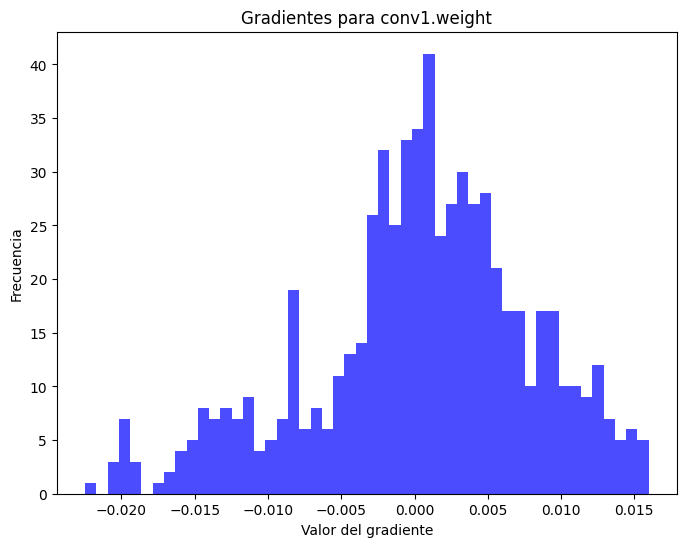

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0030532798264175653, max=0.004228345584124327, mean=-3.9442049455828965e-05, std=0.0005514936638064682


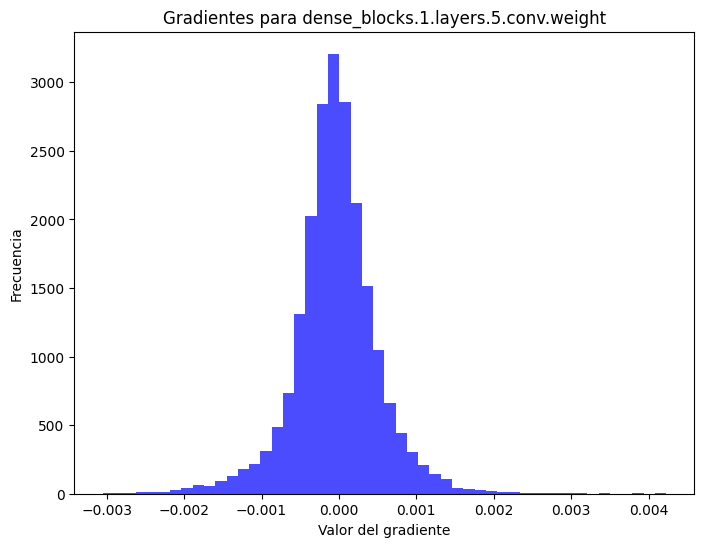

Gradientes para transition_layers.1.conv.weight: min=-0.008855650201439857, max=0.009837634861469269, mean=5.817526835016906e-05, std=0.0010492814471945167


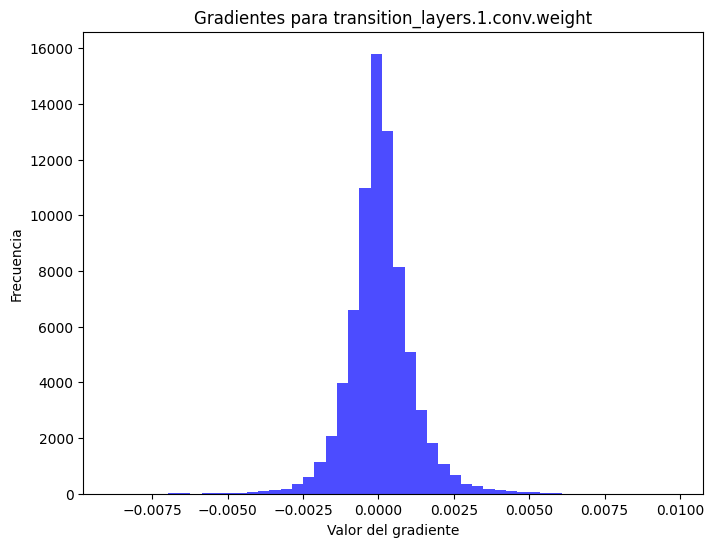

Gradientes para fc.weight: min=-0.035707078874111176, max=0.03238630294799805, mean=2.1334996269661843e-10, std=0.009615682065486908


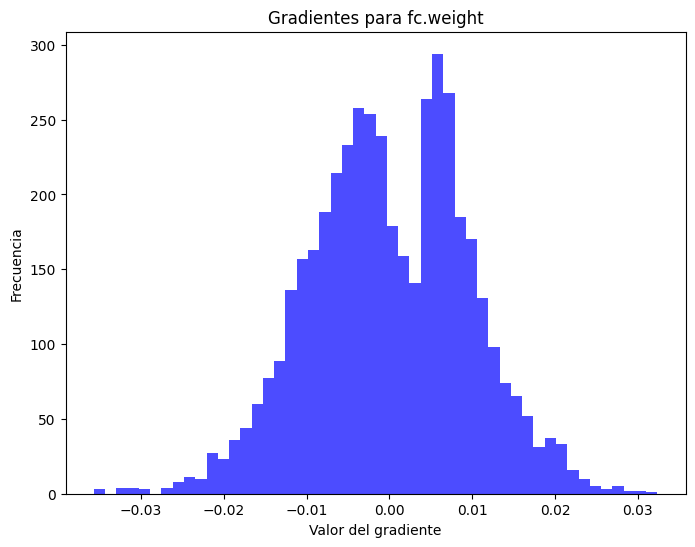

0.1
Epoch 2/70
Val loss: 1.1130, Val acc: 0.6204
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_2.pth
Checkpoint del mejor modelo guardado en la época 2
0.1
Epoch 3/70
Val loss: 1.3971, Val acc: 0.5946
0.1
Epoch 4/70
Val loss: 0.7638, Val acc: 0.7382
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_4.pth
Checkpoint del mejor modelo guardado en la época 4
0.1
Epoch 5/70
Val loss: 0.7874, Val acc: 0.7362
Gradientes para conv1.weight: min=-0.030349185690283775, max=0.01849617063999176, mean=0.0031059414613991976, std=0.008239749819040298


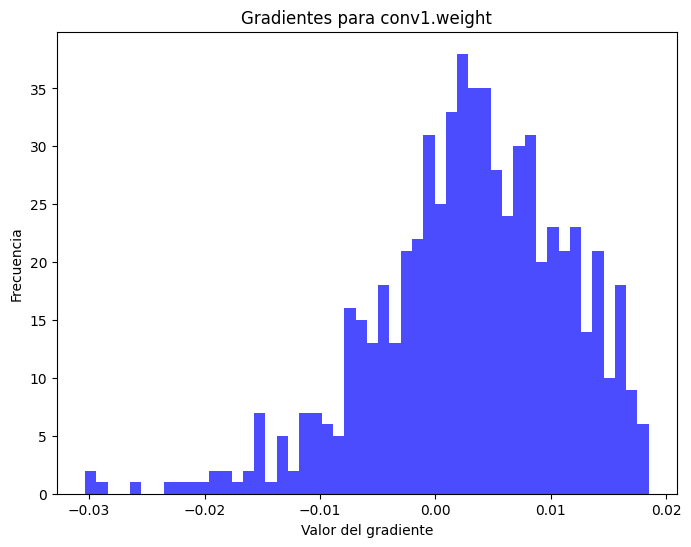

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.005448550917208195, max=0.006849161349236965, mean=-1.900586357805878e-05, std=0.0008583734161220491


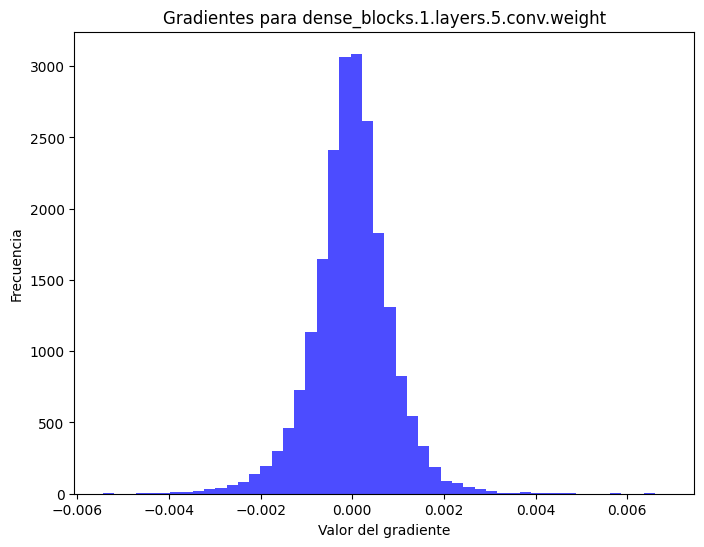

Gradientes para transition_layers.1.conv.weight: min=-0.010347811505198479, max=0.011626070365309715, mean=3.9909209590405226e-05, std=0.0015061836456879973


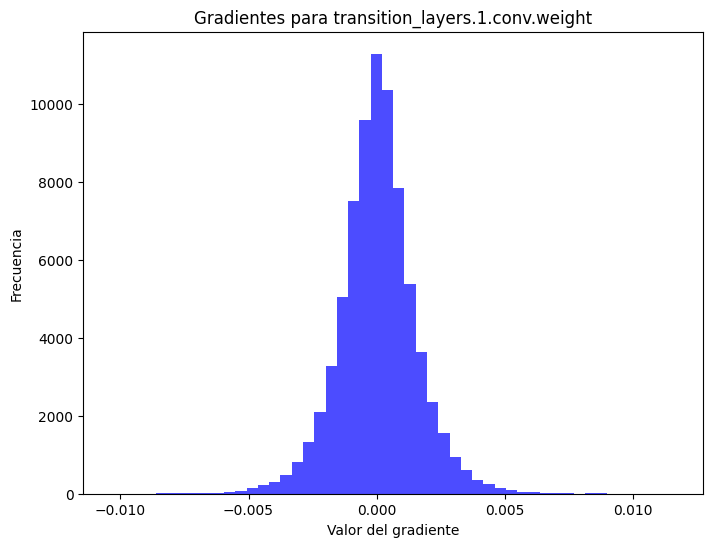

Gradientes para fc.weight: min=-0.013847529888153076, max=0.015989014878869057, mean=1.6001247549191078e-10, std=0.0030244425870478153


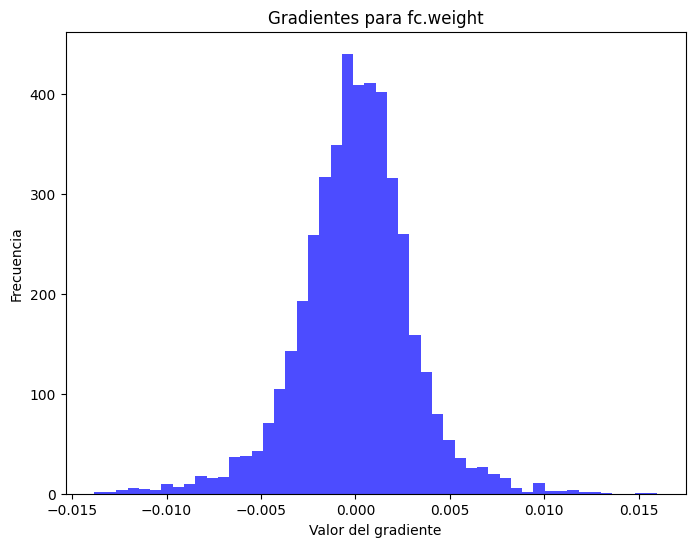

0.1
Epoch 6/70
Val loss: 0.6361, Val acc: 0.7838
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_6.pth
Checkpoint del mejor modelo guardado en la época 6
0.1
Epoch 7/70
Val loss: 0.5180, Val acc: 0.8280
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_7.pth
Checkpoint del mejor modelo guardado en la época 7
0.1
Epoch 8/70
Val loss: 0.6679, Val acc: 0.7744
0.1
Epoch 9/70
Val loss: 0.5534, Val acc: 0.8232
0.1
Epoch 10/70
Val loss: 0.4565, Val acc: 0.8412
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_10.pth
Checkpoint del mejor modelo guardado en la época 10
Gradientes para conv1.weight: min=-0.018878871574997902, max=0.02441924437880516, mean=0.00032736212597228587, std=0.007336356211453676


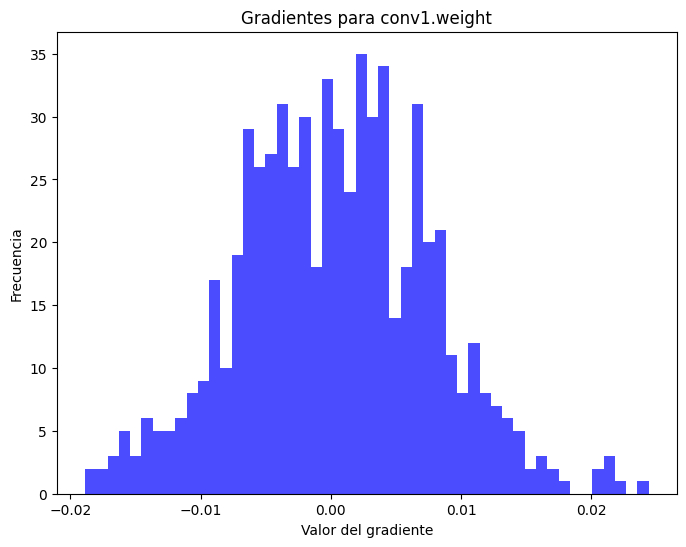

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.003809562651440501, max=0.004516498651355505, mean=3.520166137604974e-05, std=0.0008722666534595191


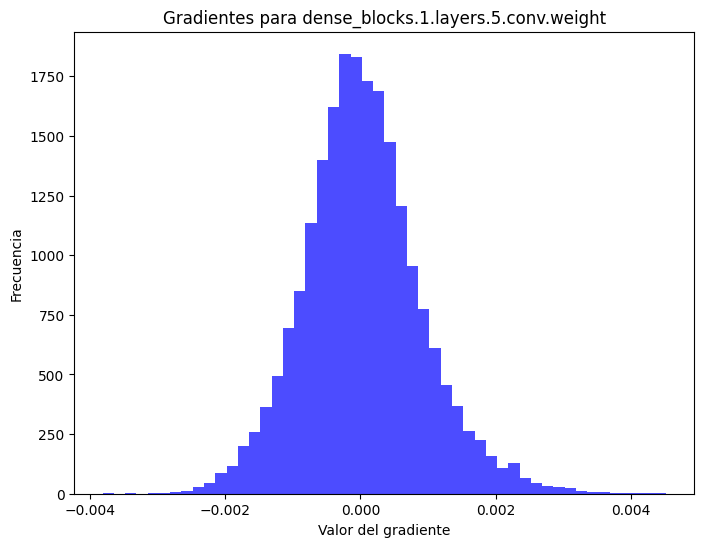

Gradientes para transition_layers.1.conv.weight: min=-0.00934610515832901, max=0.008587057702243328, mean=-6.0888505686307326e-05, std=0.0013356616254895926


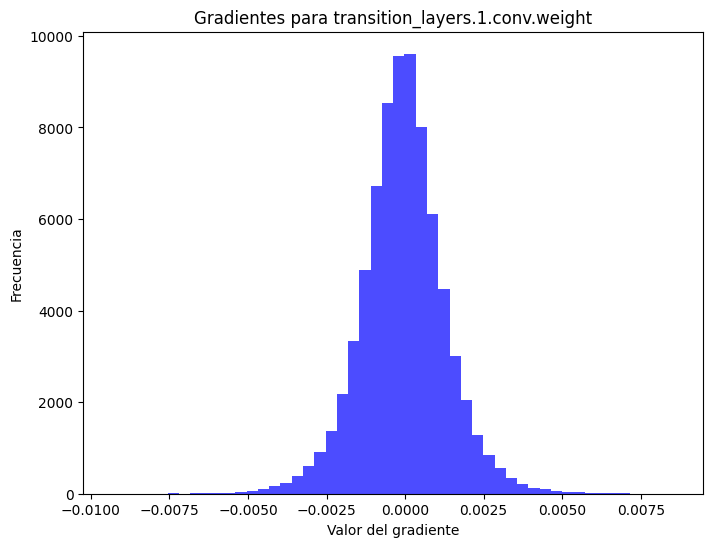

Gradientes para fc.weight: min=-0.02707410231232643, max=0.024926695972681046, mean=1.0667498134830922e-10, std=0.0032603691797703505


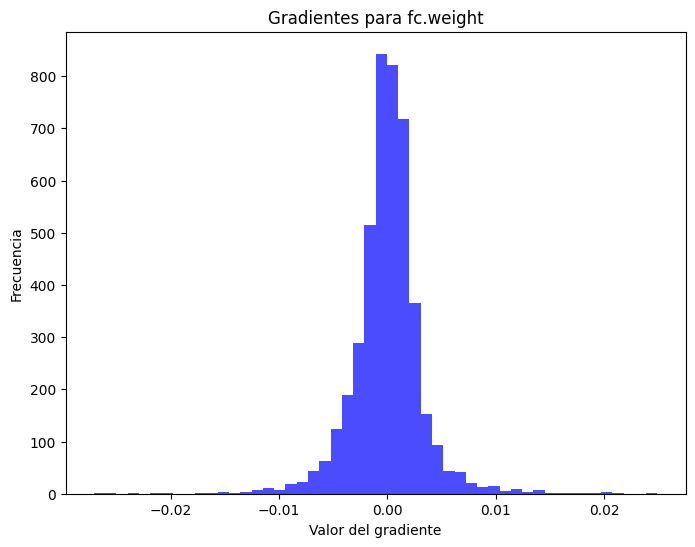

0.1
Epoch 11/70
Val loss: 0.5999, Val acc: 0.7928
0.1
Epoch 12/70
Val loss: 0.4801, Val acc: 0.8442
0.1
Epoch 13/70
Val loss: 0.4391, Val acc: 0.8536
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_13.pth
Checkpoint del mejor modelo guardado en la época 13
0.1
Epoch 14/70
Val loss: 0.5512, Val acc: 0.8252
0.1
Epoch 15/70
Val loss: 0.4476, Val acc: 0.8528
Gradientes para conv1.weight: min=-0.024954337626695633, max=0.03338604420423508, mean=6.862886220915243e-05, std=0.011070880107581615


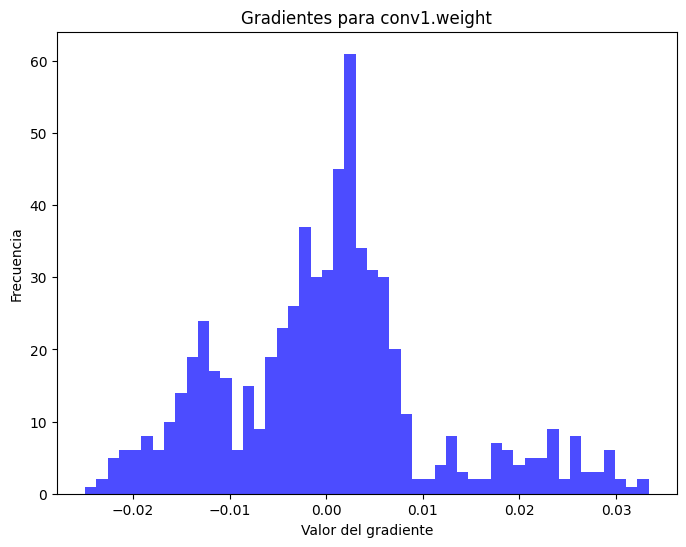

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0036668172106146812, max=0.004508706741034985, mean=3.6847293813480064e-05, std=0.0009280379745177925


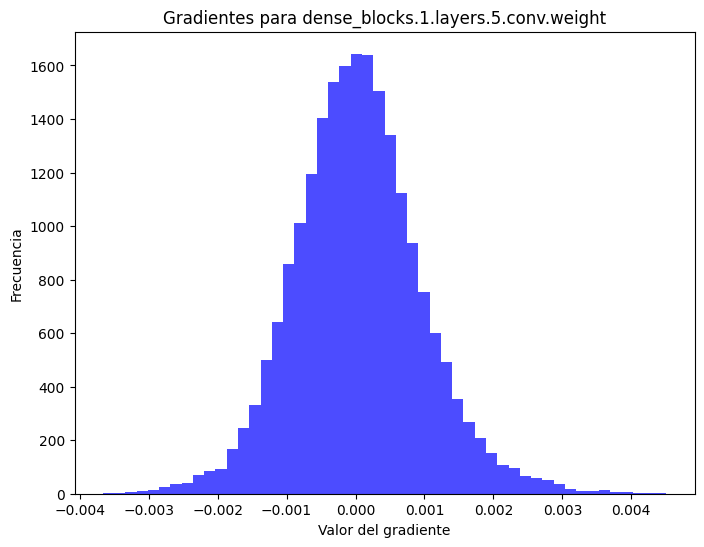

Gradientes para transition_layers.1.conv.weight: min=-0.017319703474640846, max=0.015889566391706467, mean=3.1254048735718243e-06, std=0.0016233909409493208


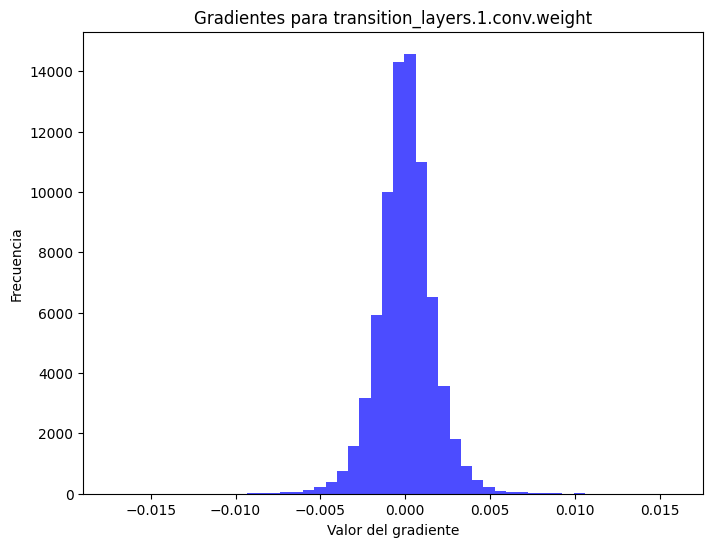

Gradientes para fc.weight: min=-0.03317945450544357, max=0.050031211227178574, mean=-9.334060607768535e-11, std=0.0053044152446091175


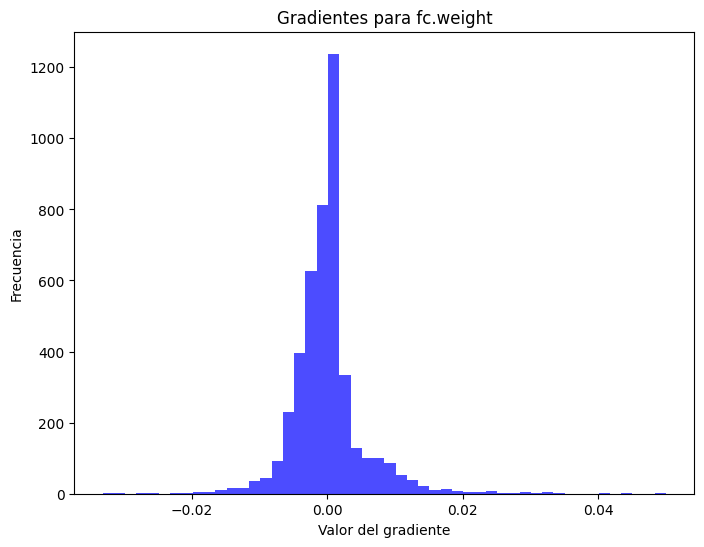

0.1
Epoch 16/70
Val loss: 0.4273, Val acc: 0.8620
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_16.pth
Checkpoint del mejor modelo guardado en la época 16
0.1
Epoch 17/70
Val loss: 0.4250, Val acc: 0.8602
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_17.pth
Checkpoint del mejor modelo guardado en la época 17
0.1
Epoch 18/70
Val loss: 0.4272, Val acc: 0.8666
0.1
Epoch 19/70
Val loss: 0.4869, Val acc: 0.8482
0.1
Epoch 20/70
Val loss: 0.4333, Val acc: 0.8628
Gradientes para conv1.weight: min=-0.030824339017271996, max=0.02778509445488453, mean=0.00020179386774543673, std=0.008880243636667728


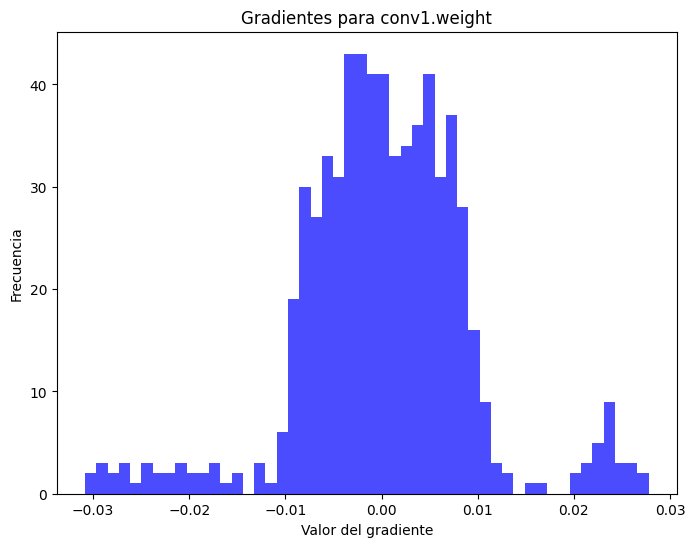

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.003986181225627661, max=0.003259708173573017, mean=-1.3899270925321616e-05, std=0.00072980992263183


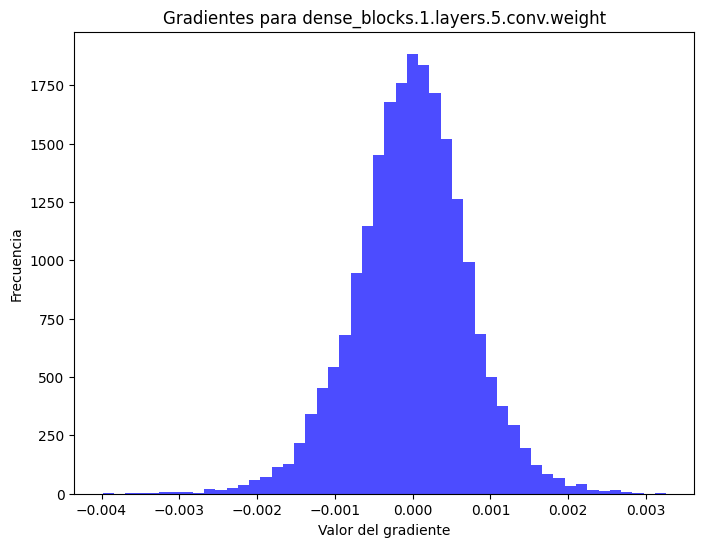

Gradientes para transition_layers.1.conv.weight: min=-0.0075829108245670795, max=0.007758142426609993, mean=1.7126090824604034e-05, std=0.0011754267616197467


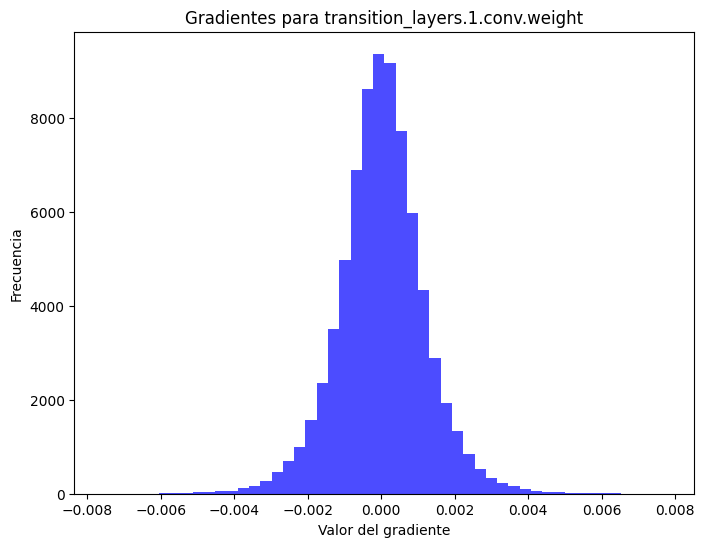

Gradientes para fc.weight: min=-0.015976671129465103, max=0.01155688613653183, mean=1.3334372495066305e-10, std=0.0020534528885036707


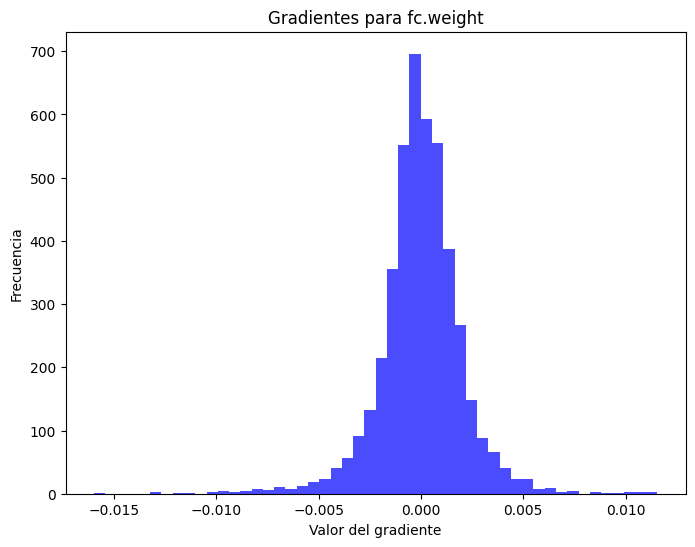

0.1
Epoch 21/70
Val loss: 0.3406, Val acc: 0.8932
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_21.pth
Checkpoint del mejor modelo guardado en la época 21
0.1
Epoch 22/70
Val loss: 0.3858, Val acc: 0.8794
0.1
Epoch 23/70
Val loss: 0.3979, Val acc: 0.8722
0.1
Epoch 24/70
Val loss: 0.3955, Val acc: 0.8848
0.1
Epoch 25/70
Val loss: 0.4659, Val acc: 0.8568
Gradientes para conv1.weight: min=-0.0134961549192667, max=0.020597245544195175, mean=0.0009894208051264286, std=0.005315146874636412


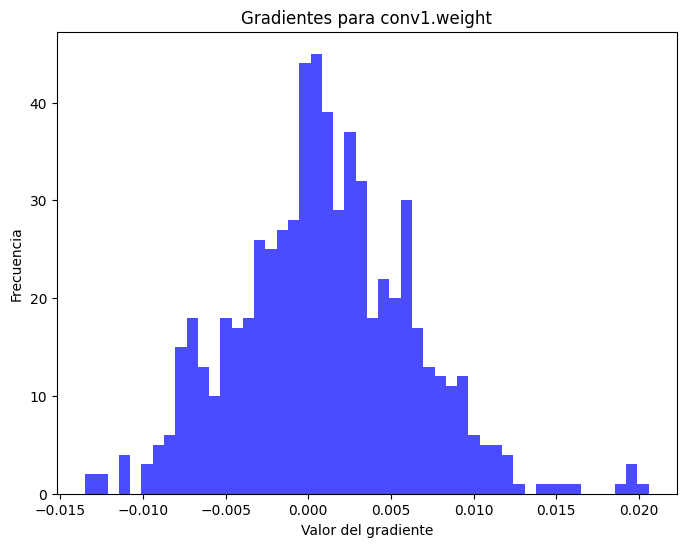

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.00375701324082911, max=0.002922618994489312, mean=9.561976185068488e-06, std=0.0006629847921431065


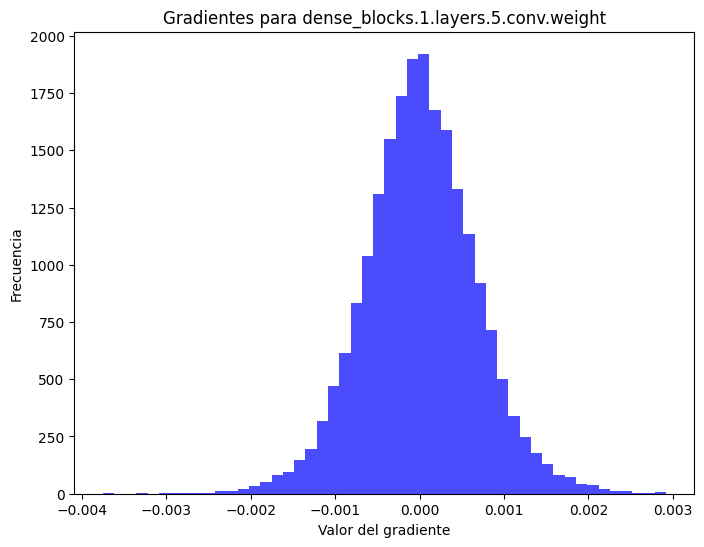

Gradientes para transition_layers.1.conv.weight: min=-0.007928834296762943, max=0.009417078457772732, mean=-1.726525511003274e-06, std=0.0011211680248379707


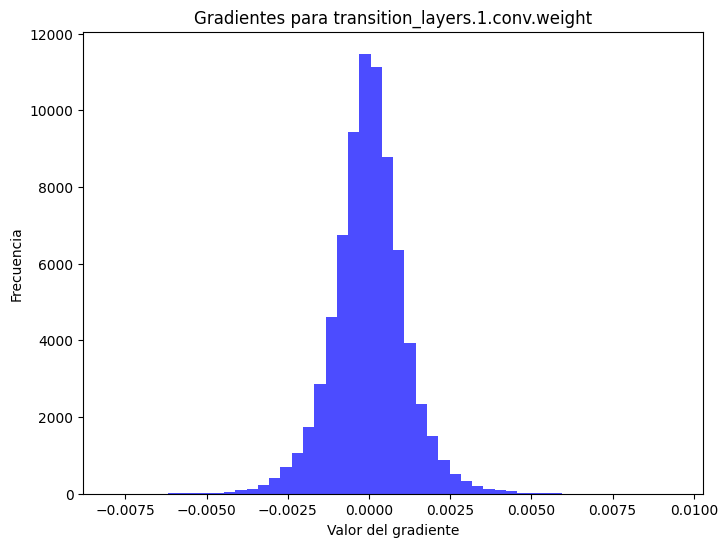

Gradientes para fc.weight: min=-0.015958772972226143, max=0.01995641179382801, mean=1.866812121553707e-10, std=0.00180329370778054


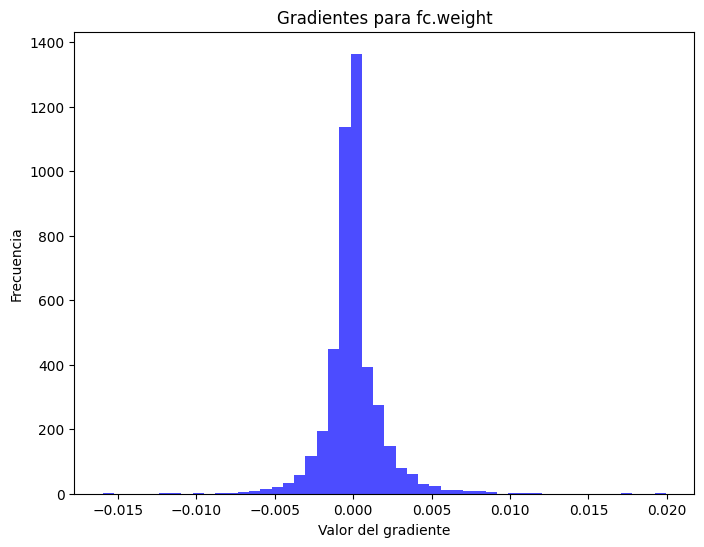

0.1
Epoch 26/70
Val loss: 0.4486, Val acc: 0.8714
0.1
Epoch 27/70
Val loss: 0.4131, Val acc: 0.8846
0.1
Epoch 28/70
Val loss: 0.3753, Val acc: 0.8914
0.1
Epoch 29/70
Val loss: 0.4535, Val acc: 0.8806
0.010000000000000002
Epoch 30/70
Val loss: 0.2843, Val acc: 0.9176
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet67_2/best_checkpoint_epoch_30.pth
Checkpoint del mejor modelo guardado en la época 30
Gradientes para conv1.weight: min=-0.013026832602918148, max=0.020443521440029144, mean=-0.0003565782681107521, std=0.005348492879420519


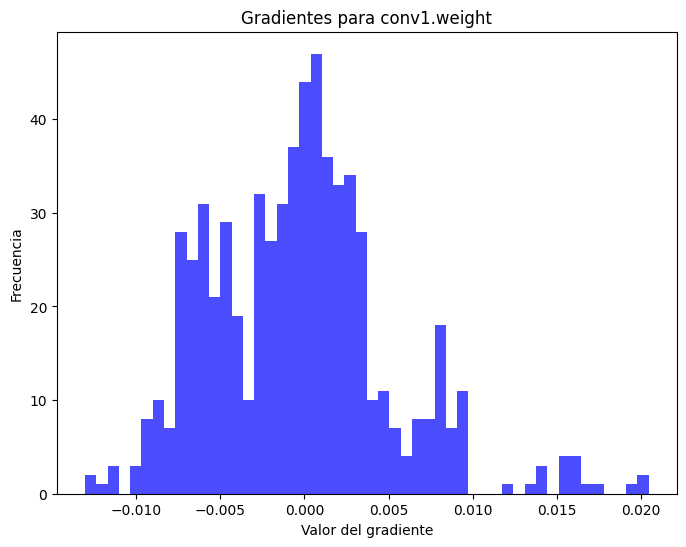

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0035434868186712265, max=0.004014721605926752, mean=9.073608453036286e-06, std=0.00064698705682531


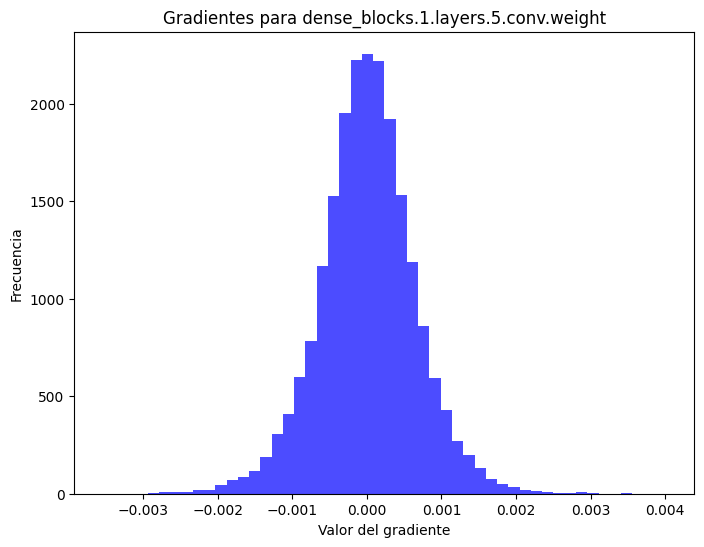

Gradientes para transition_layers.1.conv.weight: min=-0.009380009956657887, max=0.008478539995849133, mean=-1.8956901840283535e-05, std=0.0009853505762293935


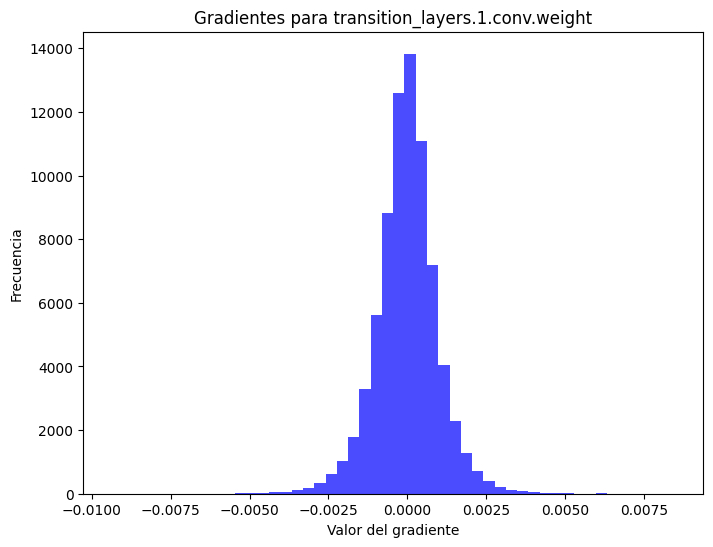

Gradientes para fc.weight: min=-0.018013503402471542, max=0.013555060140788555, mean=-6.667186247533152e-11, std=0.0017784241354092956


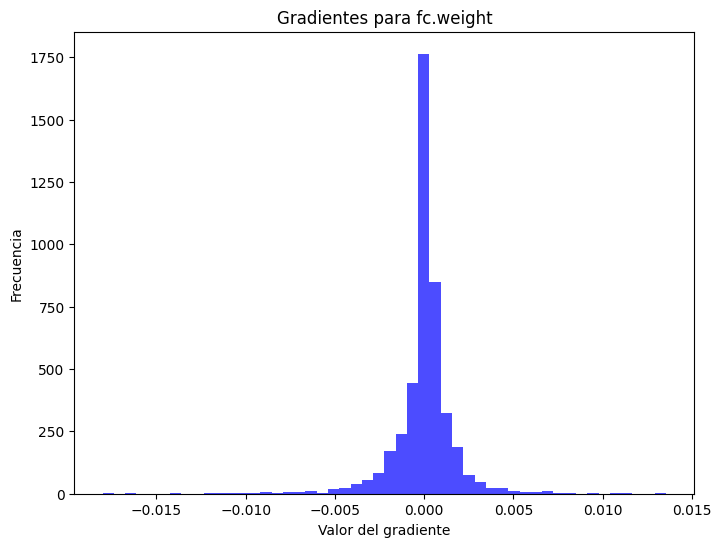

0.010000000000000002
Epoch 31/70
Val loss: 0.2860, Val acc: 0.9160
0.010000000000000002
Epoch 32/70
Val loss: 0.2893, Val acc: 0.9142
0.010000000000000002
Epoch 33/70
Val loss: 0.2931, Val acc: 0.9156
0.010000000000000002
Epoch 34/70
Val loss: 0.2943, Val acc: 0.9158
0.010000000000000002
Epoch 35/70
Val loss: 0.2957, Val acc: 0.9182
Gradientes para conv1.weight: min=-0.008729477412998676, max=0.01916777528822422, mean=-0.0008544910815544426, std=0.0038046655245125294


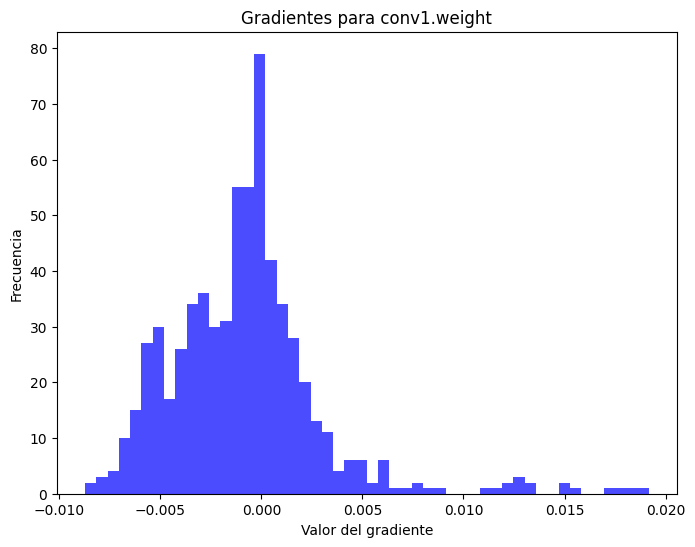

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0026795656885951757, max=0.0018395938677713275, mean=-1.3571037015935872e-05, std=0.00041142053669318557


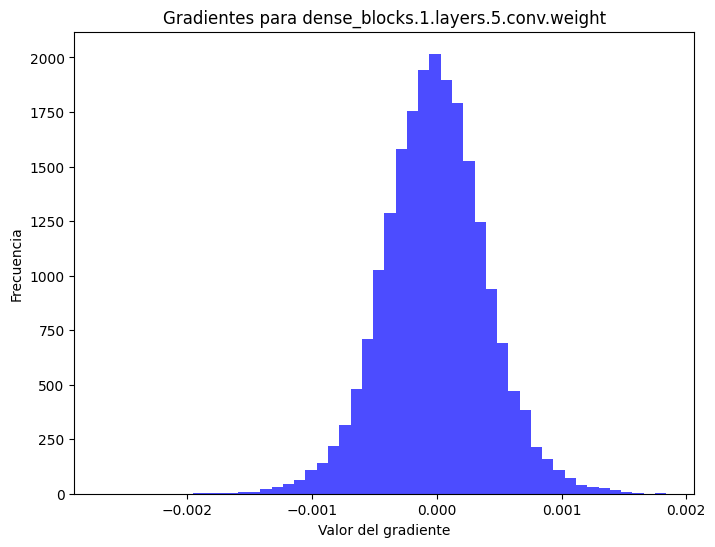

Gradientes para transition_layers.1.conv.weight: min=-0.008793751709163189, max=0.007982062175869942, mean=-6.191170882630104e-07, std=0.0007130479789339006


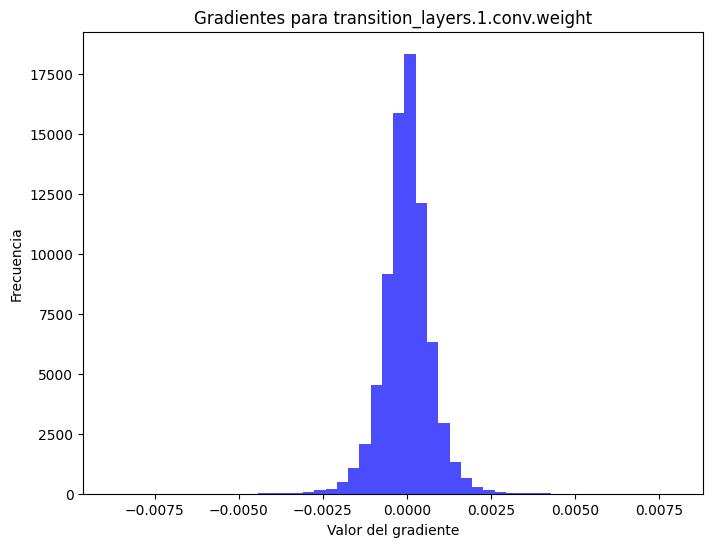

Gradientes para fc.weight: min=-0.016530152410268784, max=0.015415113419294357, mean=2.666874499013261e-10, std=0.0016873659333214164


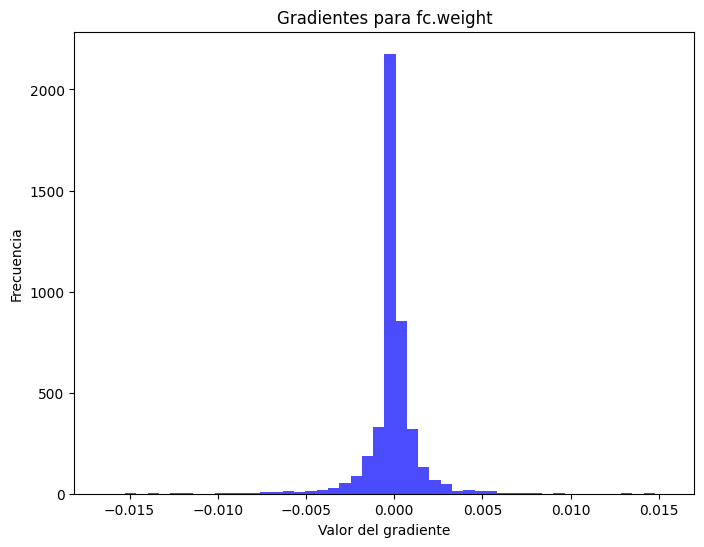

0.010000000000000002
Epoch 36/70
Val loss: 0.2965, Val acc: 0.9174
0.010000000000000002
Epoch 37/70
Val loss: 0.3107, Val acc: 0.9156
0.010000000000000002
Epoch 38/70
Val loss: 0.3149, Val acc: 0.9174
0.0010000000000000002
Epoch 39/70
Val loss: 0.3150, Val acc: 0.9172
0.0010000000000000002
Epoch 40/70
Val loss: 0.3115, Val acc: 0.9190
Gradientes para conv1.weight: min=-0.012500162236392498, max=0.005714163184165955, mean=-0.0008050691685639322, std=0.002931432332843542


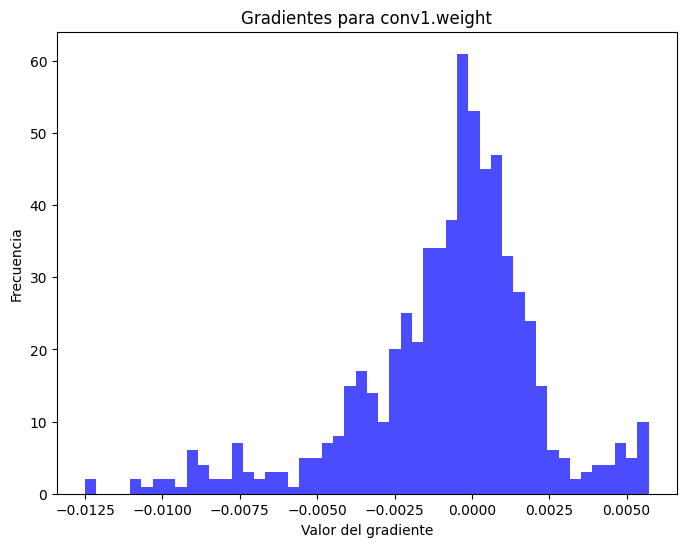

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0015099833253771067, max=0.002489384962245822, mean=5.237342975306092e-06, std=0.0003423072921577841


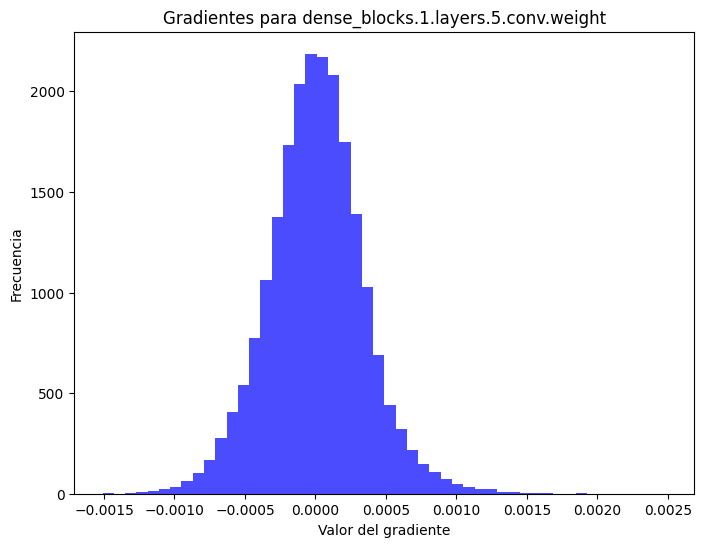

Gradientes para transition_layers.1.conv.weight: min=-0.006265649572014809, max=0.004957185126841068, mean=-6.562260750797577e-06, std=0.00059141730889678


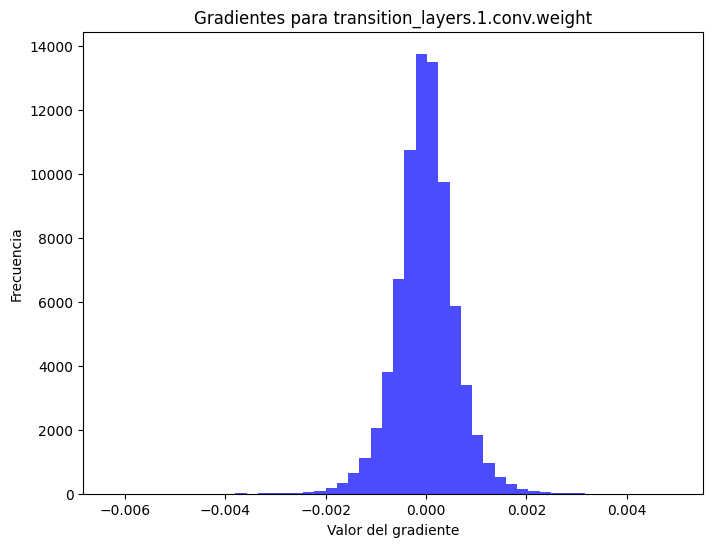

Gradientes para fc.weight: min=-0.006281132809817791, max=0.004076899494975805, mean=2.1334996269661843e-10, std=0.0006101606413722038


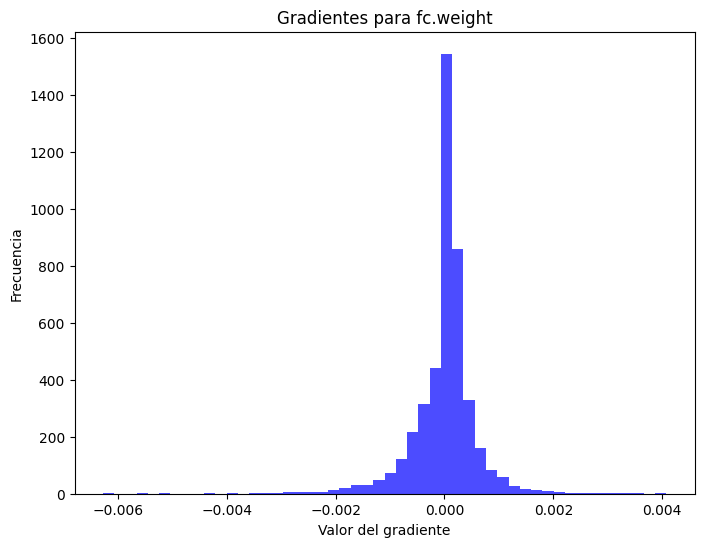

0.0010000000000000002
Epoch 41/70
Val loss: 0.3146, Val acc: 0.9170
0.0010000000000000002
Epoch 42/70
Val loss: 0.3119, Val acc: 0.9182
0.0010000000000000002
Epoch 43/70
Val loss: 0.3153, Val acc: 0.9182
0.0010000000000000002
Epoch 44/70
Val loss: 0.3124, Val acc: 0.9182
0.0010000000000000002
Epoch 45/70
Val loss: 0.3104, Val acc: 0.9170
Gradientes para conv1.weight: min=-0.023031005635857582, max=0.015874959528446198, mean=-0.00031004624906927347, std=0.004675510339438915


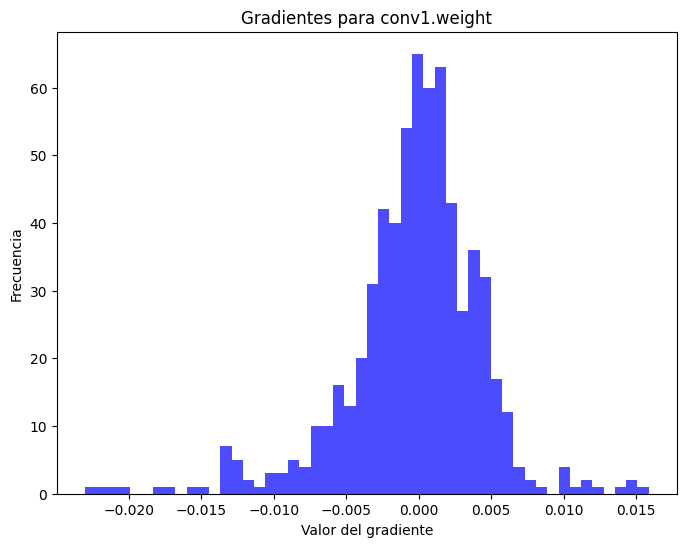

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.004401832353323698, max=0.00803784653544426, mean=-2.066159140667878e-06, std=0.0008444671984761953


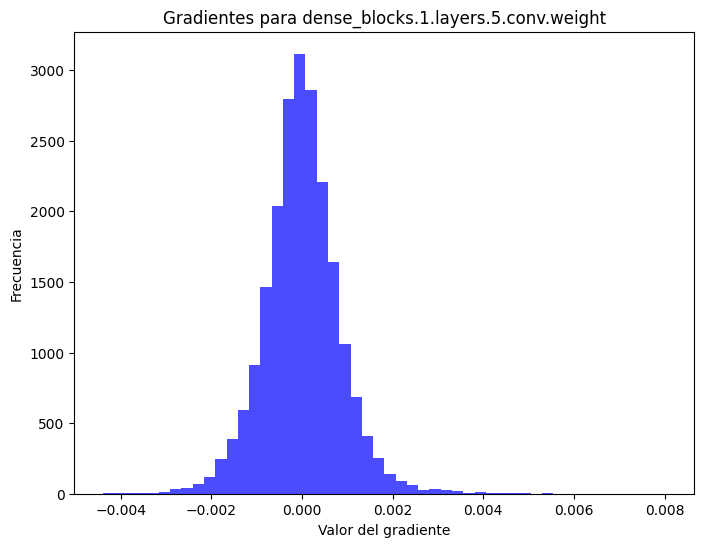

Gradientes para transition_layers.1.conv.weight: min=-0.010158452205359936, max=0.012384280562400818, mean=-7.764722795400303e-06, std=0.0011095879599452019


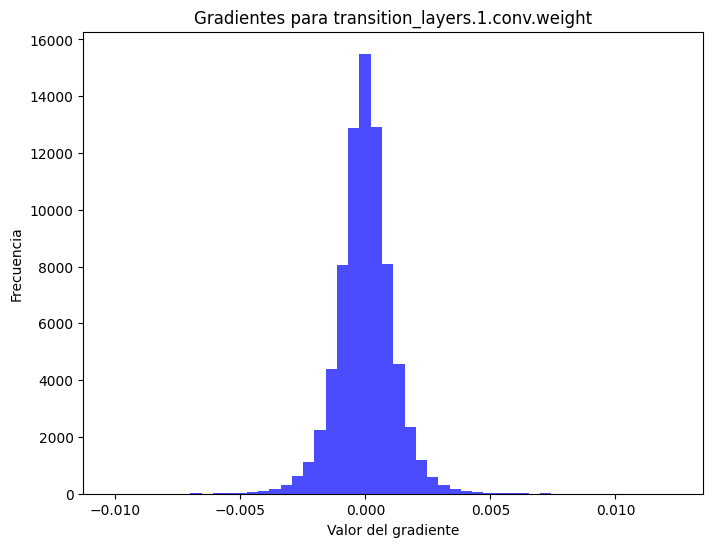

Gradientes para fc.weight: min=-0.012548473663628101, max=0.008392169140279293, mean=2.8002181129416215e-10, std=0.0012398314429447055


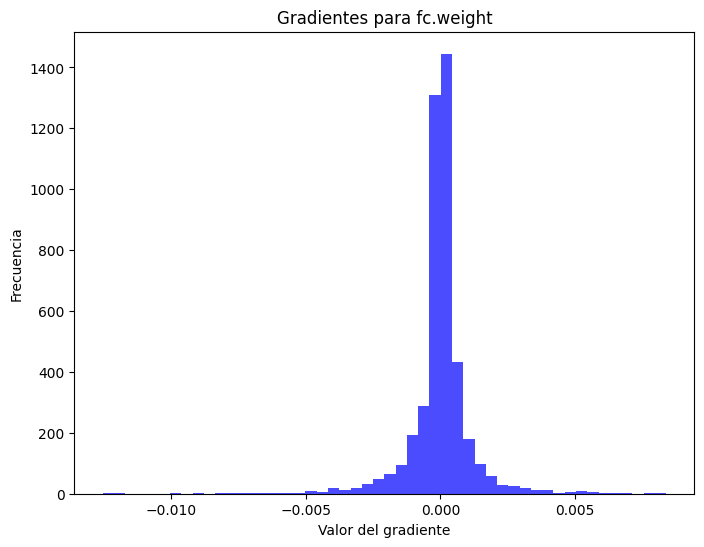

Early stopping at epoch 45

Tiempo total de entrenamiento: 9228.98 segundos


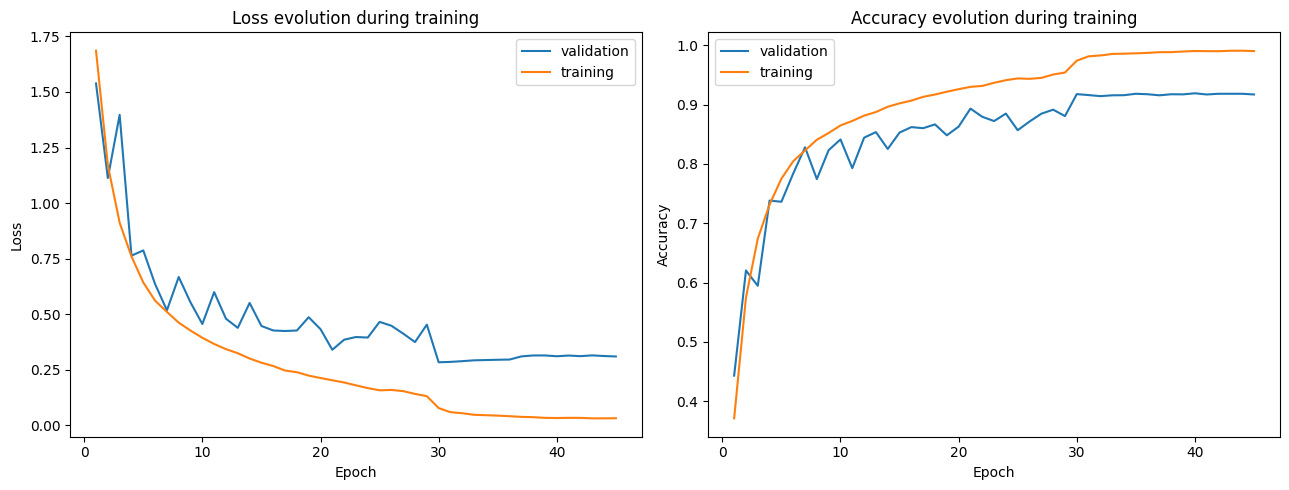

In [ ]:
use_gpu = True

# Checkpointing functions
checkpoint_dir = "/content/drive/MyDrive/CheckpointsDenseNet67_2"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 70
    max_iterations = 600000  # Ajusta según sea necesario
    learning_rate = 0.1
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-5
    early_stop_thresh = 15
    patience = 7

    # Inicializar el modelo
    model = DenseNet67(growth_rate=12, num_layers=67, reduction=0.5, num_classes=10)

    print(model)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    curves = train_model(
        model=model,
        train_dataset=train_cifar10,
        val_dataset=val_cifar10,
        epochs=epochs,
        max_iterations=max_iterations,
        criterion=criterion,
        batch_size=batch_size,
        lr=learning_rate,
        n_evaluations_per_epoch=n_evaluations_per_epoch,
        early_stop_thresh=early_stop_thresh,
        show_gradients=show_gradients_DenseNet67,
        patience=patience,
        use_gpu=use_gpu,
        data_augmentation=data_augmentation,
        resume_checkpoint=None,  # Establece a una cadena de caracteres para reanudar, por ejemplo, "best_checkpoint_epoch_10.pth"
        weight_decay=weight_decay
    )

    # Plotear curvas de entrenamiento
    show_curves(curves)

In [ ]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/CheckpointsDenseNet67_2"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

# Crear una instancia del modelo
model = DenseNet67(growth_rate=12, num_layers=67, reduction=0.5, num_classes=10)

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Crear el DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    test_cifar10,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1,5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1,5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")


Mejor modelo encontrado: best_checkpoint_epoch_30.pth


<ipython-input-11-cafff17dbb4c>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Precisión TOP1 en el conjunto de prueba: 90.92%
Precisión TOP5 en el conjunto de prueba: 99.85%


# DenseNet100
k = 12

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dense Layer
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], 1)  # Concatenate input with output

# Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([
            DenseLayer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x

# DenseNet Model
class DenseNet100(nn.Module):
    def __init__(self, growth_rate=12, num_layers=100, reduction=0.5, num_classes=10):
        super(DenseNet100, self).__init__()
        assert (num_layers - 4) % 3 == 0, "Number of layers must be 3N + 4"
        num_blocks = 3
        num_layers_per_block = (num_layers - 4) // num_blocks

        self.growth_rate = growth_rate
        num_channels = 2 * growth_rate  # Initial number of channels

        # Initial Convolution
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # Dense Blocks with Transition Layers
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()
        for i in range(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers_per_block, num_channels, growth_rate))
            num_channels += num_layers_per_block * growth_rate
            if i != num_blocks - 1:  # Add transition layer between blocks
                out_channels = int(num_channels * reduction)
                self.transition_layers.append(TransitionLayer(num_channels, out_channels))
                num_channels = out_channels

        # Final BatchNorm and Fully Connected Layer
        self.bn = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        for i, dense_block in enumerate(self.dense_blocks):
            x = dense_block(x)
            if i < len(self.transition_layers):
                x = self.transition_layers[i](x)
        x = F.relu(self.bn(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the DenseNet-100 model
model = DenseNet100(growth_rate=12, num_layers=100, reduction=0.5, num_classes=10)

In [4]:
def densenet100():
    # Crear la DenseNet-100 con los parámetros especificados
    return DenseNet100(growth_rate=12, num_layers=100, reduction=0.5, num_classes=10)

# Instanciar el modelo
model = densenet100()

# Mostrar las capas del modelo
for name, param in model.named_parameters():
    print(name)


conv1.weight
dense_blocks.0.layers.0.bn.weight
dense_blocks.0.layers.0.bn.bias
dense_blocks.0.layers.0.conv.weight
dense_blocks.0.layers.1.bn.weight
dense_blocks.0.layers.1.bn.bias
dense_blocks.0.layers.1.conv.weight
dense_blocks.0.layers.2.bn.weight
dense_blocks.0.layers.2.bn.bias
dense_blocks.0.layers.2.conv.weight
dense_blocks.0.layers.3.bn.weight
dense_blocks.0.layers.3.bn.bias
dense_blocks.0.layers.3.conv.weight
dense_blocks.0.layers.4.bn.weight
dense_blocks.0.layers.4.bn.bias
dense_blocks.0.layers.4.conv.weight
dense_blocks.0.layers.5.bn.weight
dense_blocks.0.layers.5.bn.bias
dense_blocks.0.layers.5.conv.weight
dense_blocks.0.layers.6.bn.weight
dense_blocks.0.layers.6.bn.bias
dense_blocks.0.layers.6.conv.weight
dense_blocks.0.layers.7.bn.weight
dense_blocks.0.layers.7.bn.bias
dense_blocks.0.layers.7.conv.weight
dense_blocks.0.layers.8.bn.weight
dense_blocks.0.layers.8.bn.bias
dense_blocks.0.layers.8.conv.weight
dense_blocks.0.layers.9.bn.weight
dense_blocks.0.layers.9.bn.bias
den

In [5]:
def show_gradients_DenseNet100(model):
    # Capas clave seleccionadas para la visualización
    layers_to_show = [
        'conv1.weight',                           # Capa inicial
        'dense_blocks.1.layers.5.conv.weight',    # Capa intermedia (Bloque 2, capa 5)
        'transition_layers.1.conv.weight',        # Capa de transición 2
        'fc.weight'                               # Capa final
    ]

    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_show) and param.requires_grad and param.grad is not None:
            grad = param.grad.cpu().numpy()
            print(f"Gradientes para {name}: min={grad.min()}, max={grad.max()}, mean={grad.mean()}, std={grad.std()}")
            plt.figure(figsize=(8, 6))
            plt.hist(grad.flatten(), bins=50)
            plt.title(f'Gradientes para {name}')
            plt.xlabel('Valor del gradiente')
            plt.ylabel('Frecuencia')
            plt.show()

DenseNet100(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense_blocks): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (bn): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(36, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (2): DenseLayer(
          (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (3): DenseLayer(
   

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Val loss: 1.3711, Val acc: 0.5254
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_1.pth
Checkpoint del mejor modelo guardado en la época 1
Gradientes para conv1.weight: min=-0.04481187090277672, max=0.041685253381729126, mean=0.0017832090379670262, std=0.01731281355023384


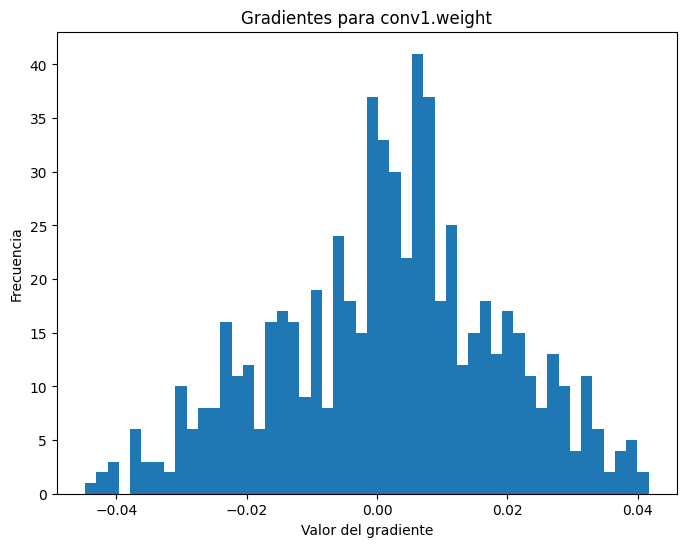

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.0029873198363929987, max=0.0031783725135028362, mean=-1.5861534848227166e-05, std=0.0007034476730041206


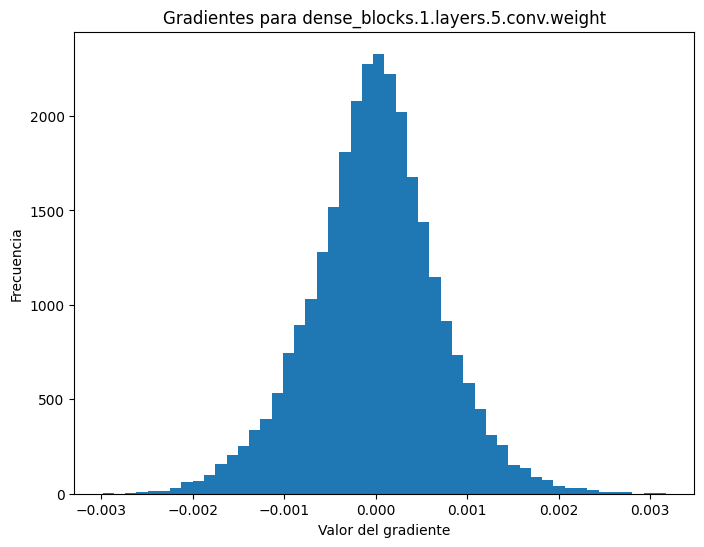

Gradientes para transition_layers.1.conv.weight: min=-0.008092277683317661, max=0.007987627759575844, mean=4.4261710172577295e-06, std=0.0010653503704816103


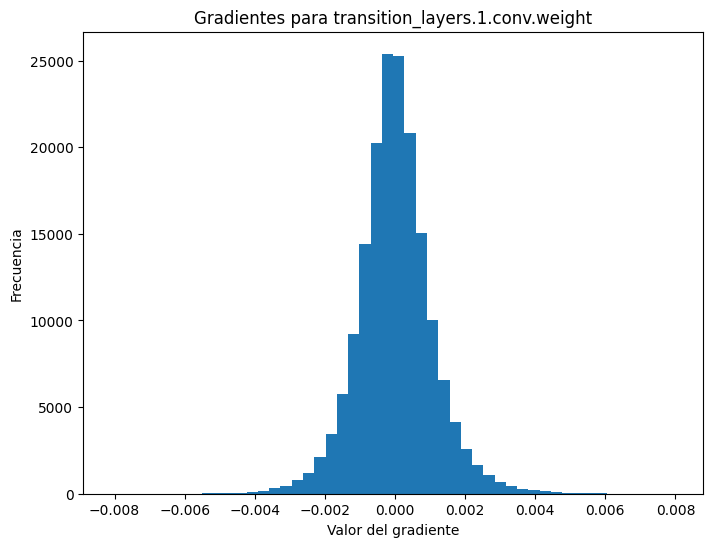

Gradientes para fc.weight: min=-0.0463724248111248, max=0.03889114409685135, mean=2.8131985629897827e-10, std=0.010495470836758614


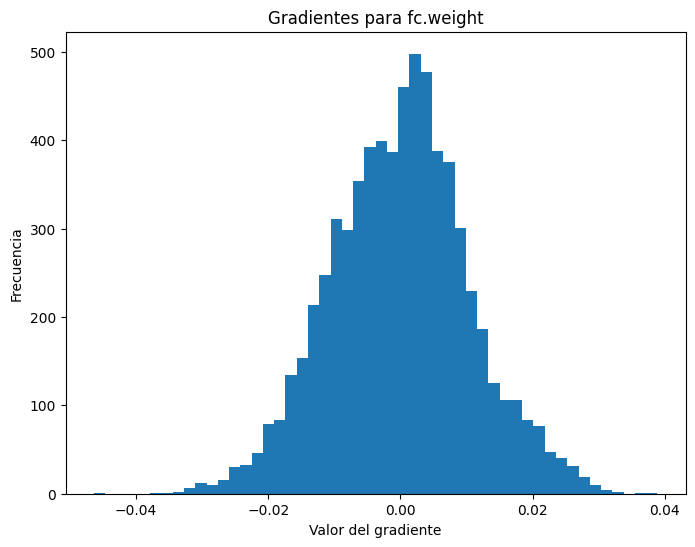

0.04
Epoch 2/70
Val loss: 1.0009, Val acc: 0.6532
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_2.pth
Checkpoint del mejor modelo guardado en la época 2
0.04
Epoch 3/70
Val loss: 0.8762, Val acc: 0.6916
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_3.pth
Checkpoint del mejor modelo guardado en la época 3
0.04
Epoch 4/70
Val loss: 0.8966, Val acc: 0.7164
0.04
Epoch 5/70
Val loss: 0.6067, Val acc: 0.7890
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_5.pth
Checkpoint del mejor modelo guardado en la época 5
Gradientes para conv1.weight: min=-0.029231198132038116, max=0.027718110010027885, mean=0.00045938114635646343, std=0.011619023978710175


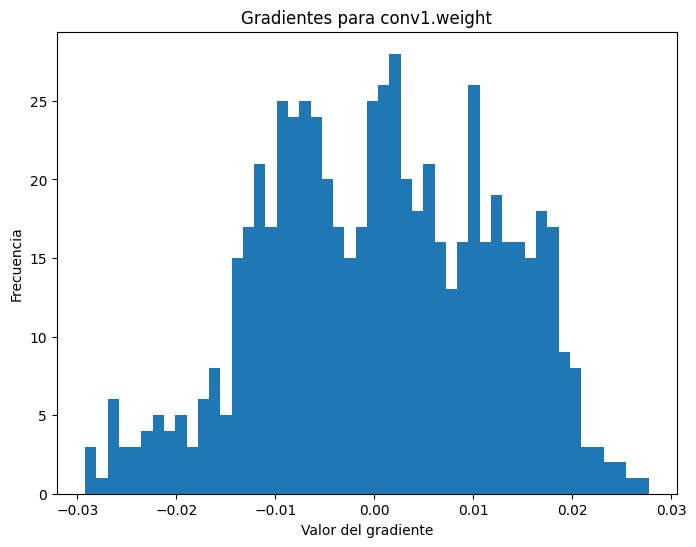

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.00417458638548851, max=0.005881300661712885, mean=9.10810922505334e-06, std=0.0009406907483935356


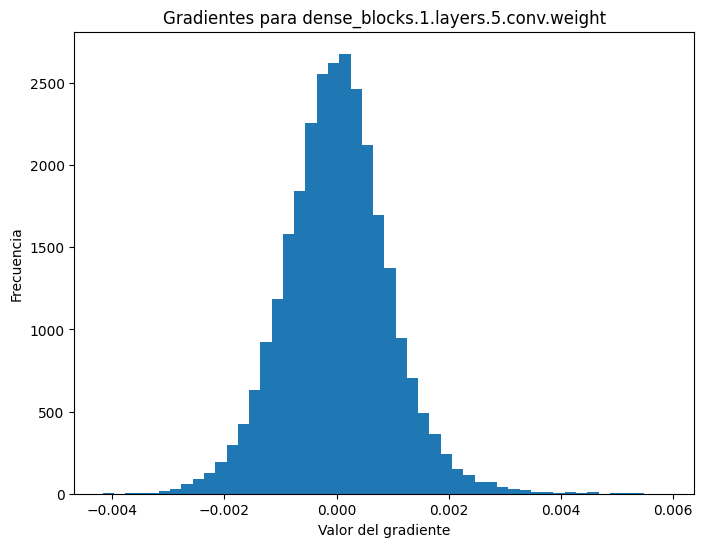

Gradientes para transition_layers.1.conv.weight: min=-0.011132991872727871, max=0.009957006201148033, mean=2.1827558157383464e-05, std=0.0012284484691917896


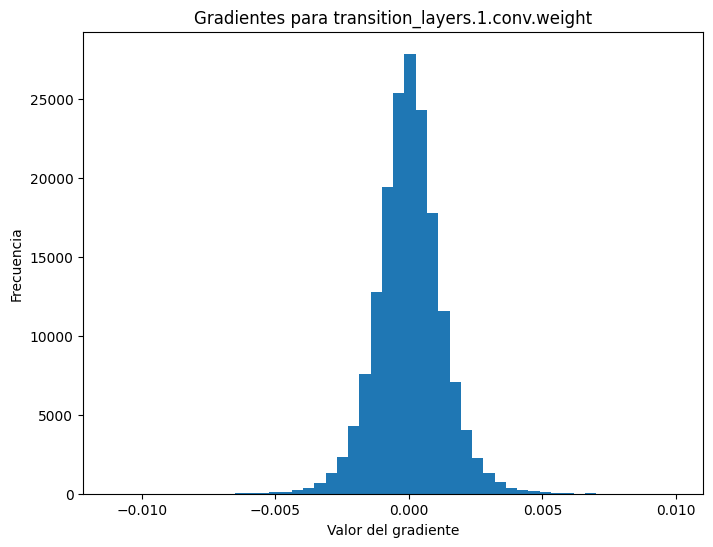

Gradientes para fc.weight: min=-0.038038987666368484, max=0.023711564019322395, mean=0.0, std=0.006976830307394266


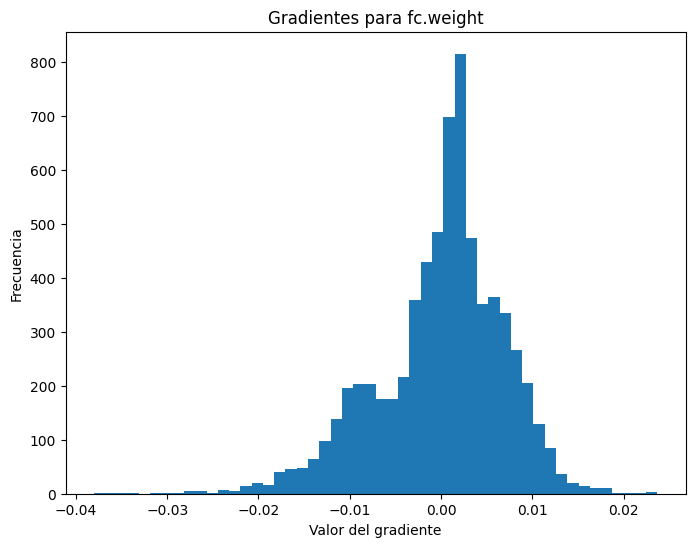

0.04
Epoch 6/70
Val loss: 0.5441, Val acc: 0.8114
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_6.pth
Checkpoint del mejor modelo guardado en la época 6
0.04
Epoch 7/70
Val loss: 0.6785, Val acc: 0.7840
0.04
Epoch 8/70
Val loss: 0.6392, Val acc: 0.7950
0.04
Epoch 9/70
Val loss: 0.5572, Val acc: 0.8212
0.04
Epoch 10/70
Val loss: 0.9304, Val acc: 0.7342
Gradientes para conv1.weight: min=-0.02872464433312416, max=0.031281400471925735, mean=0.0012821952113881707, std=0.01072688028216362


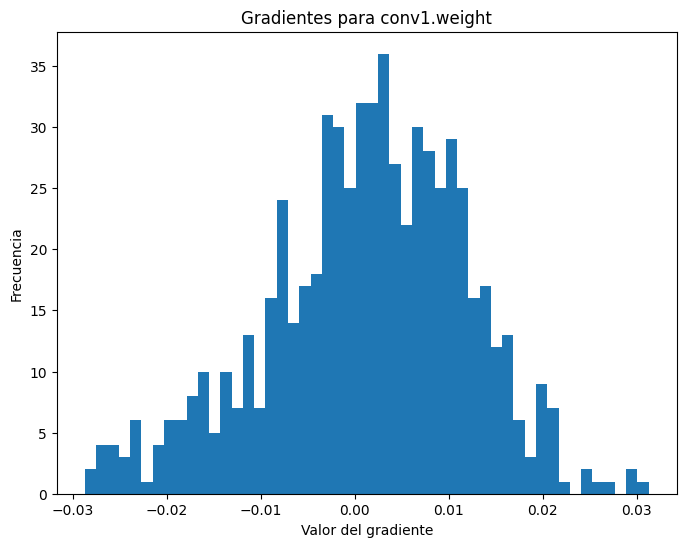

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.004768329672515392, max=0.004645267501473427, mean=3.238477074773982e-05, std=0.000969802204053849


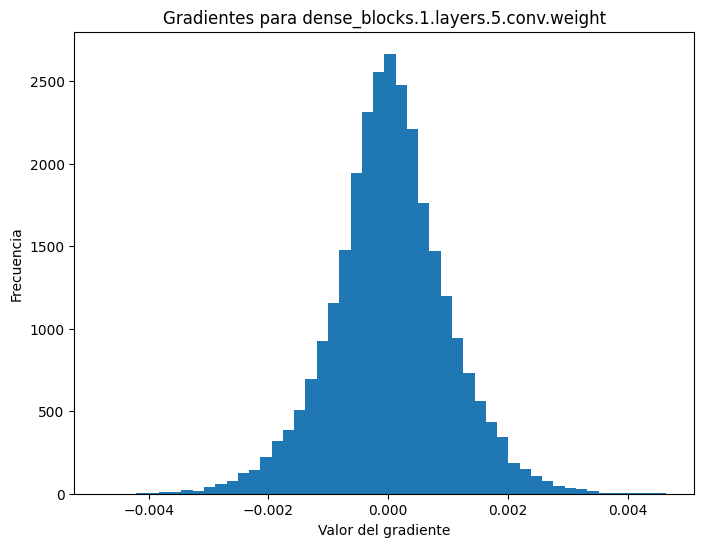

Gradientes para transition_layers.1.conv.weight: min=-0.008887030184268951, max=0.0104868458583951, mean=-1.0381659194536041e-05, std=0.0013180893147364259


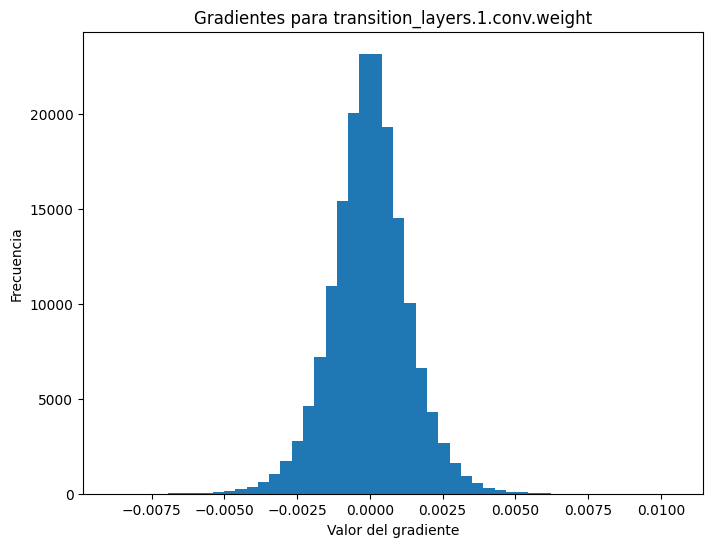

Gradientes para fc.weight: min=-0.020419377833604813, max=0.018321432173252106, mean=2.109898922242337e-10, std=0.004157069139182568


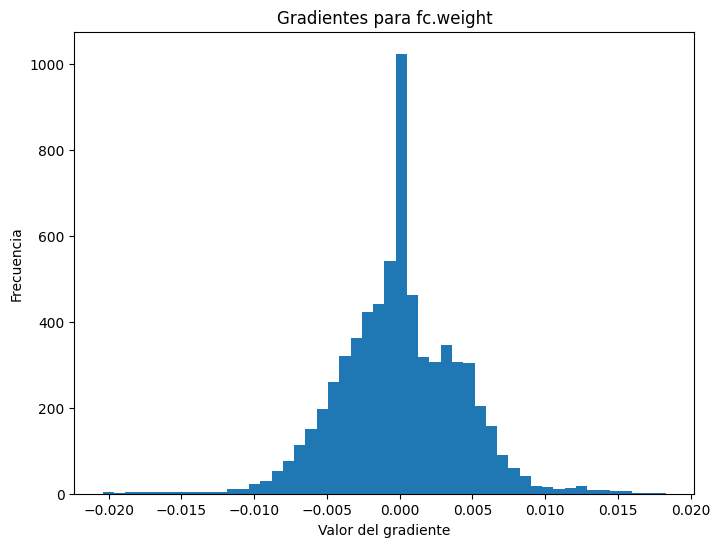

0.004
Epoch 11/70
Val loss: 0.3131, Val acc: 0.8926
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_11.pth
Checkpoint del mejor modelo guardado en la época 11
0.004
Epoch 12/70
Val loss: 0.3078, Val acc: 0.8968
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_12.pth
Checkpoint del mejor modelo guardado en la época 12
0.004
Epoch 13/70
Val loss: 0.3043, Val acc: 0.9000
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_13.pth
Checkpoint del mejor modelo guardado en la época 13
0.004
Epoch 14/70
Val loss: 0.3012, Val acc: 0.8988
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_14.pth
Checkpoint del mejor modelo guardado en la época 14
0.004
Epoch 15/70
Val loss: 0.3017, Val acc: 0.8984
Gradientes para conv1.weight: min=-0.032878708094358444, max=0.023446399718523026, mean=0.00023611349752172828, std=0.009432529099285603


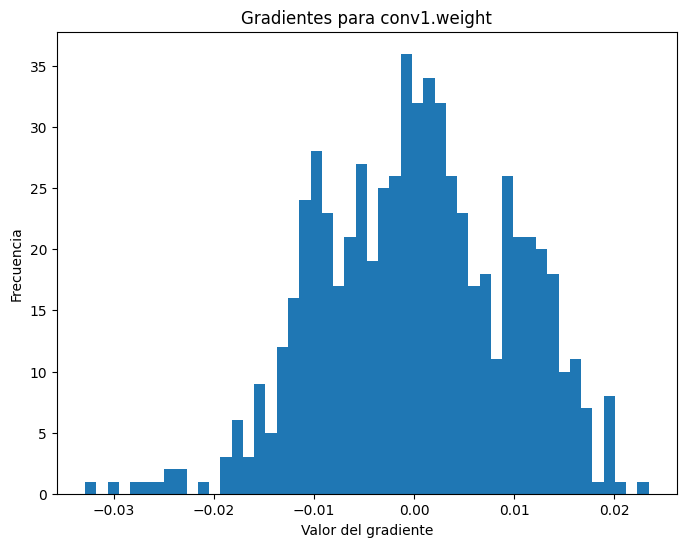

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.004617496859282255, max=0.0040871924720704556, mean=-1.4774934243177995e-05, std=0.0008402899838984013


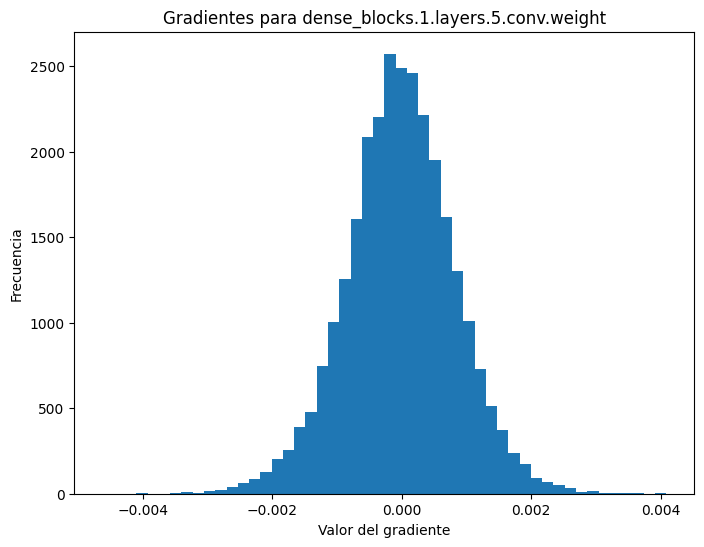

Gradientes para transition_layers.1.conv.weight: min=-0.013170521706342697, max=0.012265285477042198, mean=-9.027554597196286e-07, std=0.0013701561838388443


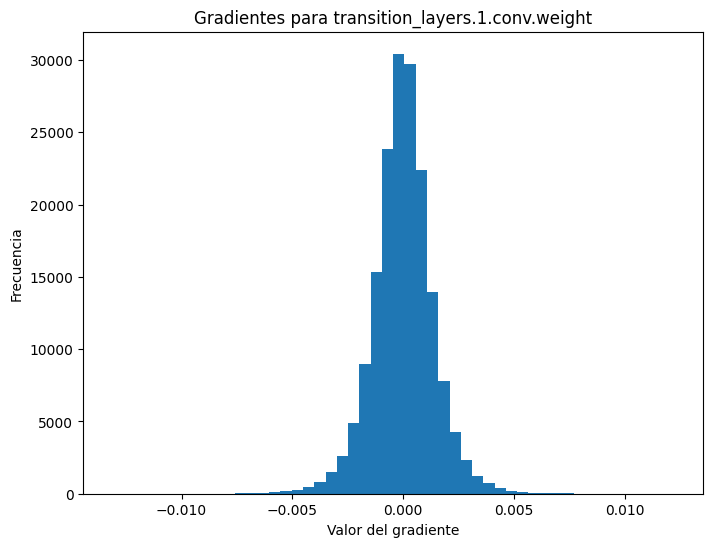

Gradientes para fc.weight: min=-0.03993888199329376, max=0.03168574720621109, mean=3.5164982037372283e-10, std=0.004924957174807787


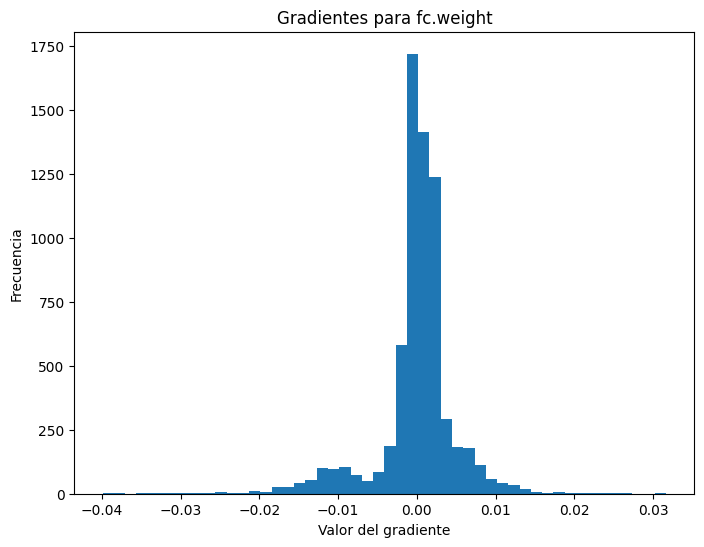

0.004
Epoch 16/70
Val loss: 0.3061, Val acc: 0.8998
0.004
Epoch 17/70
Val loss: 0.3076, Val acc: 0.8960
0.004
Epoch 18/70
Val loss: 0.2977, Val acc: 0.8982
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_18.pth
Checkpoint del mejor modelo guardado en la época 18
0.004
Epoch 19/70
Val loss: 0.3096, Val acc: 0.8992
0.004
Epoch 20/70
Val loss: 0.3092, Val acc: 0.8972
Gradientes para conv1.weight: min=-0.02118816040456295, max=0.022946175187826157, mean=0.0022366042248904705, std=0.00755753880366683


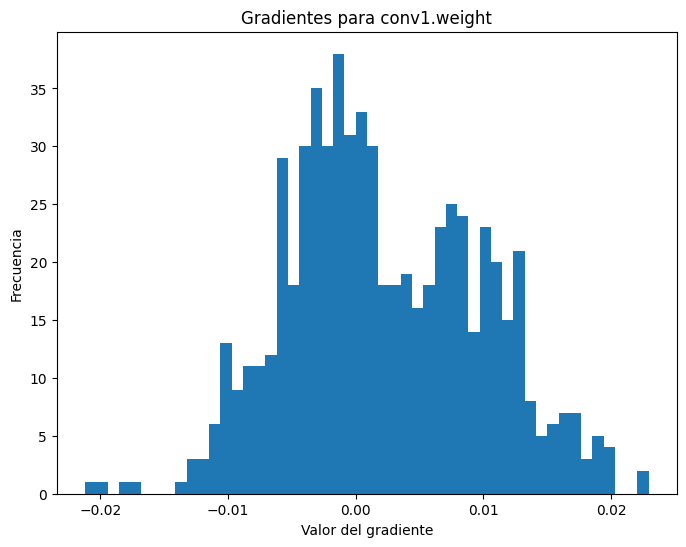

Gradientes para dense_blocks.1.layers.5.conv.weight: min=-0.005059105809777975, max=0.007840091362595558, mean=3.3665852242847905e-05, std=0.0009110748651437461


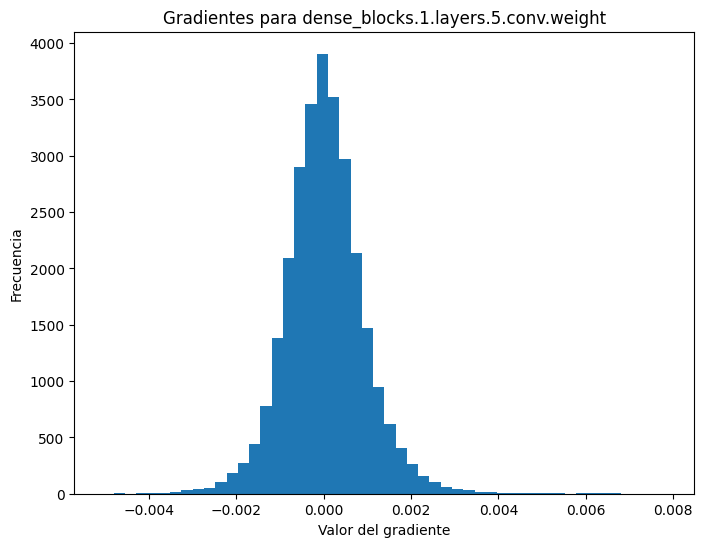

Gradientes para transition_layers.1.conv.weight: min=-0.012097403407096863, max=0.011984114535152912, mean=3.617462198235444e-06, std=0.0011181319132447243


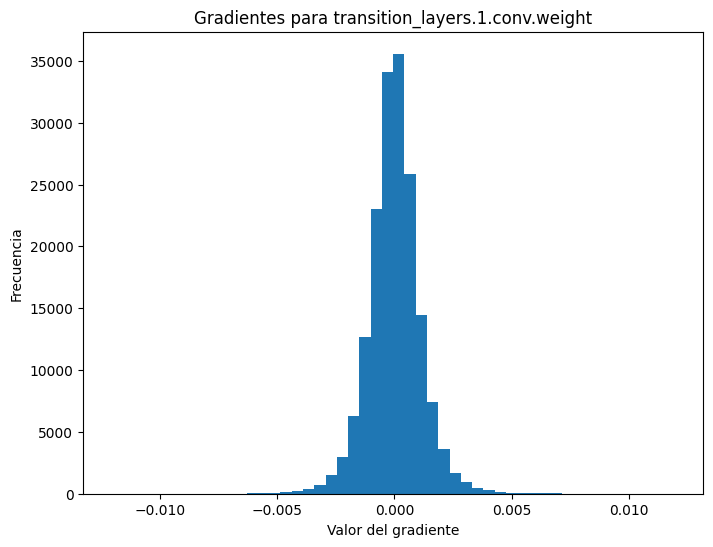

Gradientes para fc.weight: min=-0.014971059747040272, max=0.0113464230671525, mean=2.109898922242337e-10, std=0.002469992032274604


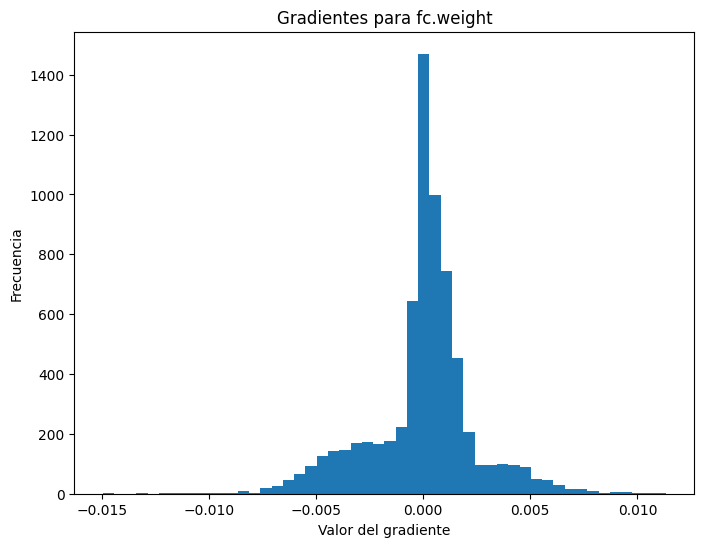

0.004
Epoch 21/70
Val loss: 0.3000, Val acc: 0.9018
0.004
Epoch 22/70
Val loss: 0.3104, Val acc: 0.8974
0.0004
Epoch 23/70
Val loss: 0.2901, Val acc: 0.9046
Checkpoint guardado en /content/drive/MyDrive/CheckpointsDenseNet100/best_checkpoint_epoch_23.pth
Checkpoint del mejor modelo guardado en la época 23
0.0004
Epoch 24/70


In [ ]:
use_gpu = True

# Checkpointing functions
checkpoint_dir = "/content/drive/MyDrive/CheckpointsDenseNet100"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize feature map dictionary
feature_maps = {}
if __name__ == "__main__":
    # Hiperparámetros
    batch_size = 128
    epochs = 70
    max_iterations = 600000  # Ajusta según sea necesario
    learning_rate = 0.04
    n_evaluations_per_epoch = 10
    use_gpu = torch.cuda.is_available()
    data_augmentation = True
    weight_decay = 1e-4
    early_stop_thresh = 15
    patience = 3

    # Inicializar el modelo
    model = densenet100()

    print(model)

    # Definir función de pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenar el modelo
    curves = train_model(
        model=model,
        train_dataset=train_cifar10,
        val_dataset=val_cifar10,
        epochs=epochs,
        max_iterations=max_iterations,
        criterion=criterion,
        batch_size=batch_size,
        lr=learning_rate,
        n_evaluations_per_epoch=n_evaluations_per_epoch,
        early_stop_thresh=early_stop_thresh,
        show_gradients=show_gradients_DenseNet100,
        patience=patience,
        use_gpu=use_gpu,
        data_augmentation=data_augmentation,
        resume_checkpoint=None,  # Establece a una cadena de caracteres para reanudar, por ejemplo, "best_checkpoint_epoch_10.pth"
        weight_decay=weight_decay
    )

    # Plotear curvas de entrenamiento
    show_curves(curves)

In [ ]:
# Definir el directorio donde se guardaron los checkpoints
checkpoint_dir = "/content/drive/MyDrive/CheckpointsDenseNet100"

# Obtener la lista de archivos de checkpoint
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [f for f in checkpoint_files if f.startswith('best_checkpoint_epoch_') and f.endswith('.pth')]

# Encontrar el checkpoint con el número de época más alto (el mejor modelo)
epochs_in_checkpoints = []
for f in checkpoint_files:
    epoch_str = f.replace('best_checkpoint_epoch_', '').replace('.pth', '')
    try:
        epoch_num = int(epoch_str)
        epochs_in_checkpoints.append((epoch_num, f))
    except ValueError:
        continue

if epochs_in_checkpoints:
    best_epoch, best_checkpoint_file = max(epochs_in_checkpoints)
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint_file)
    print(f"Mejor modelo encontrado: {best_checkpoint_file}")
else:
    print("No se encontraron archivos de checkpoint")
    # Manejar el error apropiadamente
    raise FileNotFoundError("No se encontraron archivos de checkpoint.")

# Crear una instancia del modelo
model = densenet100()

# Configurar el dispositivo (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Preparar el conjunto de prueba y el DataLoader

# Crear el DataLoader para el conjunto de prueba
test_loader = torch.utils.data.DataLoader(
    test_cifar10,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Definir la función para evaluar TOP1 y TOP5
def evaluate_topk(loader, model, device, k=(1,5)):
    model.eval()
    topk_accs = [0] * len(k)
    data_count = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(k), dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))
            for i, kk in enumerate(k):
                correct_k = correct[:kk].reshape(-1).float().sum(0, keepdim=True)
                topk_accs[i] += correct_k.item()
            data_count += labels.size(0)
    topk_accs = [acc / data_count for acc in topk_accs]
    return topk_accs

# Evaluar el modelo en el conjunto de prueba
top1_acc, top5_acc = evaluate_topk(test_loader, model, device, k=(1,5))

print(f"Precisión TOP1 en el conjunto de prueba: {top1_acc * 100:.2f}%")
print(f"Precisión TOP5 en el conjunto de prueba: {top5_acc * 100:.2f}%")